In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from prophet import Prophet

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics


## Lectura y limpieza de datos
- lectura del .csv
- vista de los tipos de datos en DF original
- Creacion del df_todos que es identico al original, pero solo con las 4 columnas importantes

DF hasta noviembre (entrenamiento)
DF del mes de noviembre (testeo)
- Luego se crean otros 2 DF partiendo de las 2 anteriores:
  -  con las sumatorias de las ventas por dia



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pd.set_option('display.float_format', '{:.4f}'.format)


In [4]:
# si se importa desde Drive
file_path = '/content/drive/MyDrive/DIPLOMADO/Proy_Final/datos/tabla_13_modif_top10ventas_nov_v2.csv'
# si se importa subiendo el archivo
# file_name = "tabla_11_modif_top10ventas_nov.csv"
df = pd.read_csv(file_path)
df.head()

,CodigoSucursal,CodigoDepartamento,CodigoEstado,TipoMovimiento,DescripcionMovimiento,NumeroMovimiento,NumeroCorrelativo,FechaMovimiento,NombreProducto,UnidadMedida,CantidadSalida,PesoSalida,MontoBase,PrecioUnitario,CostoUnitario,MontoReferencia,NombreGrupo
0,13,1,AC,SVE,VENTA COMPUTARIZADA,18112056,0,2018-11-15,CUELLO,KG,0.0000,0.6532,2.5760,3.5880,3.5880,0.3698,TROZADO
1,13,1,AC,SVE,VENTA COMPUTARIZADA,18112055,0,2018-11-15,FILETE A GRANEL,KG,0.0000,1.9826,47.0120,21.8040,21.8040,6.7546,TROZADO
2,13,1,AC,SVE,VENTA COMPUTARIZADA,18112052,0,2018-11-15,FILETE A GRANEL,KG,0.0000,1.9246,45.6320,21.8040,21.8040,6.5559,TROZADO
3,13,1,AC,SVE,VENTA COMPUTARIZADA,18112050,0,2018-11-15,FILETE A GRANEL,KG,0.0000,0.8418,19.9640,21.8040,21.8040,2.8686,TROZADO
4,13,1,AC,SVE,VENTA COMPUTARIZADA,18112049,0,2018-11-15,PIERNA,KG,0.0000,0.1334,2.1160,14.7200,14.7200,0.3036,TROZADO


In [5]:
df['FechaMovimiento'] = pd.to_datetime(df['FechaMovimiento'])
df['year'] = df['FechaMovimiento'].dt.year
df.dtypes

CodigoSucursal                    int64
CodigoDepartamento                int64
CodigoEstado                     object
TipoMovimiento                   object
DescripcionMovimiento            object
NumeroMovimiento                  int64
NumeroCorrelativo                 int64
FechaMovimiento          datetime64[ns]
NombreProducto                   object
UnidadMedida                     object
CantidadSalida                  float64
PesoSalida                      float64
MontoBase                       float64
PrecioUnitario                  float64
CostoUnitario                   float64
MontoReferencia                 float64
NombreGrupo                      object
year                              int64
dtype: object

In [6]:
df_todo = df[['NombreProducto',
              'FechaMovimiento',
              'MontoBase',
              'year'
              ]]

In [7]:
#df_todo = df_todo.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo.sort_values(by='FechaMovimiento', inplace=True)

<ipython-input-7-3f20b1242116>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo.sort_values(by='FechaMovimiento', inplace=True)


### seleccion del top 1

In [8]:
# Obtener los nombres de los 10 productos más vendidos
top_10_productos = df_todo.groupby('NombreProducto')['MontoBase'].sum().sort_values(ascending=False).head(10)

# Imprimir los nombres de los productos
print("Nombres de los 10 productos más vendidos:")
print(top_10_productos.index)

# Obtener los días de venta para cada producto
dias_de_venta_por_producto = df_todo.groupby(['NombreProducto', 'FechaMovimiento'])['MontoBase'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.groupby('NombreProducto')['FechaMovimiento'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.rename(columns={'FechaMovimiento': 'DiasDeVenta'})
dias_de_venta_por_producto = dias_de_venta_por_producto.sort_values(by='DiasDeVenta', ascending=False).reset_index(drop=True)

# Imprimir los días de venta para cada producto
print("\nDías de venta para cada producto:")
print(dias_de_venta_por_producto)

# Seleccionar el nombre del primer producto
nombre_primer_producto = top_10_productos.index[0]

# Crear un DataFrame solo con las ventas del primer producto y un registro por día
df_top_1 = df_todo[df_todo['NombreProducto'] == nombre_primer_producto].groupby(['FechaMovimiento', 'NombreProducto']).sum().reset_index()

# Imprimir el DataFrame df_top_1
print("\nDataFrame df_top_1:")
print(df_top_1)

Nombres de los 10 productos más vendidos:
Index(['POLLO ESPECIAL', 'POLLO SIN MENUDENCIA H-C', 'PIERNA MUSLO', 'PECHUGA',
       'FILETE A GRANEL', 'ALA PRIMERA', 'PIERNA', 'MUSLO', 'CUELLO',
       'HIGADO'],
      dtype='object', name='NombreProducto')

Días de venta para cada producto:
             NombreProducto  DiasDeVenta
0            POLLO ESPECIAL         1731
1                    PIERNA         1671
2  POLLO SIN MENUDENCIA H-C         1650
3           FILETE A GRANEL         1603
4                     MUSLO         1588
5                    CUELLO         1456
6              PIERNA MUSLO         1408
7                   PECHUGA         1399
8                    HIGADO         1364
9               ALA PRIMERA         1321

DataFrame df_top_1:
     FechaMovimiento  NombreProducto  MontoBase   year
0         2018-11-01  POLLO ESPECIAL  1140.6240  26234
1         2018-11-02  POLLO ESPECIAL  1645.2540  58522
2         2018-11-03  POLLO ESPECIAL   712.9790  16144
3         2018-11-

In [9]:
# Filtrar los registros de noviembre 2023
df_noviembre = df_top_1[(df_top_1['FechaMovimiento'] >= '2023-11-01') & (df_top_1['FechaMovimiento'] <= '2023-11-30')]

# Restar los registros de noviembre del conjunto original
df_todo_hasta_nov = df_top_1[df_top_1['FechaMovimiento'] < '2023-11-01']

df_top_1 = df_top_1[df_top_1['FechaMovimiento'] < '2023-12-01']

In [10]:
print("todo ", df_todo.shape)
print("sin noviembre ", df_todo_hasta_nov.shape)
print("noviembre 2023 ", df_noviembre.shape)

todo  (196059, 4)
sin noviembre  (1698, 4)
noviembre 2023  (29, 4)


In [11]:
#df_noviembre.head()
print(df_top_1)

     FechaMovimiento  NombreProducto  MontoBase   year
0         2018-11-01  POLLO ESPECIAL  1140.6240  26234
1         2018-11-02  POLLO ESPECIAL  1645.2540  58522
2         2018-11-03  POLLO ESPECIAL   712.9790  16144
3         2018-11-04  POLLO ESPECIAL  1343.6330  50450
4         2018-11-05  POLLO ESPECIAL  1755.2580  70630
...              ...             ...        ...    ...
1722      2023-11-26  POLLO ESPECIAL   736.9200  28322
1723      2023-11-27  POLLO ESPECIAL  1955.9174  48552
1724      2023-11-28  POLLO ESPECIAL  1918.5018  34391
1725      2023-11-29  POLLO ESPECIAL  2103.6930  32368
1726      2023-11-30  POLLO ESPECIAL  1831.7624  58667

[1727 rows x 4 columns]


In [12]:
df_noviembre.tail()

,FechaMovimiento,NombreProducto,MontoBase,year
1722,2023-11-26,POLLO ESPECIAL,736.9200,28322
1723,2023-11-27,POLLO ESPECIAL,1955.9174,48552
1724,2023-11-28,POLLO ESPECIAL,1918.5018,34391
1725,2023-11-29,POLLO ESPECIAL,2103.6930,32368
1726,2023-11-30,POLLO ESPECIAL,1831.7624,58667


In [13]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        # Filtrar valores donde y_true es distinto de 0
        non_zero_indices = np.where(y_true != 0)
        y_true, y_pred = np.array(y_true)[non_zero_indices], np.array(y_pred)[non_zero_indices]

        if len(y_true) == 0:
            # Si no hay valores válidos, retornar un valor especial (por ejemplo, np.nan)
            return np.nan

        # Calcular MAPE solo para los valores válidos
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Contar valores reales y omitidos
    total_dias = len(y_true)
    dias_reales = np.sum(y_true != 0)
    dias_omitidos = total_dias - dias_reales

    print('Evaluation metric results:  ')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'MRSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
    print("---" * 10)
    print(f'Días reales calculados: {dias_reales}')
    print(f'Días omitidos: {dias_omitidos}')
    print(f'Total de días: {total_dias}')
    print("---" * 10)
    print("\n")

In [14]:
df_noviembre_sumaT = df_noviembre[[
                                    'FechaMovimiento',
                                    'NombreProducto',
                                    'MontoBase',
                                    ]]
df_noviembre_sumaT = df_noviembre_sumaT.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

print(df_noviembre_sumaT.head(10))
print(df_noviembre_sumaT.dtypes)
print(df_noviembre_sumaT.shape)

df_noviembre_desde_2021 = df_noviembre_sumaT.copy()

  FechaMovimiento  MontoBase
0      2023-11-01  1999.7321
1      2023-11-02  1011.2892
2      2023-11-03  2343.7883
3      2023-11-04  1673.2089
4      2023-11-05  1181.9289
5      2023-11-06   863.7984
6      2023-11-07  1648.4580
7      2023-11-08  1434.6711
8      2023-11-09  1680.6493
9      2023-11-10  1767.7892
FechaMovimiento    datetime64[ns]
MontoBase                 float64
dtype: object
(29, 2)


# PROPHET


### Preparado de los DataFrame

In [15]:
## Sumar las ventas por día en df_noviembre
# Primero cambiamos la columna ds a datatime
df_noviembre['FechaMovimiento'] = pd.to_datetime(df_noviembre['FechaMovimiento'])
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])
# se quitan las horas de la columna de tiempo
df_noviembre['FechaMovimiento'] = df_noviembre['FechaMovimiento'].dt.date
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
# se suman todas las ventas por dia
df_noviembre_prophet = df_noviembre.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
df_todo_hasta_nov_prophet = df_todo_hasta_nov.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

df_noviembre_prophet = df_noviembre_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo_hasta_nov_prophet = df_todo_hasta_nov_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})

print(df_noviembre.head)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.head)
print(df_todo_hasta_nov.dtypes)
print("----Prophet----")
print(df_noviembre_prophet.head)
print(df_noviembre_prophet.dtypes)
print(df_todo_hasta_nov_prophet.head)
print(df_todo_hasta_nov_prophet.dtypes)

<bound method NDFrame.head of      FechaMovimiento  NombreProducto  MontoBase   year
1698      2023-11-01  POLLO ESPECIAL  1999.7321  30345
1699      2023-11-02  POLLO ESPECIAL  1011.2892  38437
1700      2023-11-03  POLLO ESPECIAL  2343.7883  50575
1701      2023-11-04  POLLO ESPECIAL  1673.2089  34391
1702      2023-11-05  POLLO ESPECIAL  1181.9289  12138
1703      2023-11-06  POLLO ESPECIAL   863.7984  10115
1704      2023-11-07  POLLO ESPECIAL  1648.4580  36414
1705      2023-11-08  POLLO ESPECIAL  1434.6711  22253
1706      2023-11-09  POLLO ESPECIAL  1680.6493  54621
1707      2023-11-10  POLLO ESPECIAL  1767.7892  32368
1708      2023-11-11  POLLO ESPECIAL  1634.3693  28322
1709      2023-11-12  POLLO ESPECIAL   773.2943  30345
1710      2023-11-13  POLLO ESPECIAL  1415.9722  30345
1711      2023-11-14  POLLO ESPECIAL  1897.6758  22253
1712      2023-11-15  POLLO ESPECIAL  2099.2341  16184
1713      2023-11-16  POLLO ESPECIAL  1211.0052  26299
1714      2023-11-18  POLLO ESPECIA

In [16]:
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])

df_todo_hasta_nov_desde_2021 = df_todo_hasta_nov[~(df_todo_hasta_nov['FechaMovimiento'].dt.year < 2021)]

print(df_noviembre.dtypes)
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov_desde_2021.head())
print(df_todo_hasta_nov_desde_2021.dtypes)

# se devuelve el tipo object a ds para prophet
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
df_todo_hasta_nov_desde_2021['FechaMovimiento'] = df_todo_hasta_nov_desde_2021['FechaMovimiento'].dt.date

print("---" *10)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov.shape)
print(df_todo_hasta_nov_desde_2021.head())
print(df_todo_hasta_nov_desde_2021.dtypes)
print(df_todo_hasta_nov_desde_2021.shape)

FechaMovimiento     object
NombreProducto      object
MontoBase          float64
year                 int64
dtype: object
FechaMovimiento    datetime64[ns]
NombreProducto             object
MontoBase                 float64
year                        int64
dtype: object
    FechaMovimiento  NombreProducto  MontoBase   year
700      2021-01-02  POLLO ESPECIAL  1822.6310  36378
701      2021-01-03  POLLO ESPECIAL   543.4340   2021
702      2021-01-04  POLLO ESPECIAL  1221.7920  36378
703      2021-01-05  POLLO ESPECIAL  1963.7850  50525
704      2021-01-06  POLLO ESPECIAL  1012.1080  34357
FechaMovimiento    datetime64[ns]
NombreProducto             object
MontoBase                 float64
year                        int64
dtype: object
------------------------------
FechaMovimiento     object
NombreProducto      object
MontoBase          float64
year                 int64
dtype: object
FechaMovimiento     object
NombreProducto      object
MontoBase          float64
year                

<ipython-input-16-d6719813a328>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo_hasta_nov_desde_2021['FechaMovimiento'] = df_todo_hasta_nov_desde_2021['FechaMovimiento'].dt.date


In [17]:
# #primero cambiamos la columna ds a datatime
# df_noviembre['ds'] = pd.to_datetime(df_noviembre['ds'])
# df_todo_hasta_nov['ds'] = pd.to_datetime(df_todo_hasta_nov['ds'])
# # se quitan las horas de la columna de tiempo
# df_noviembre['ds'] = df_noviembre['ds'].dt.date
# df_todo_hasta_nov['ds'] = df_todo_hasta_nov['ds'].dt.date
# se suman todas las ventas por dia

df_todo_hasta_nov_desde_2021_prophet = df_todo_hasta_nov_desde_2021.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
df_todo_hasta_nov_desde_2021_prophet = df_todo_hasta_nov_desde_2021_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})

print(df_todo_hasta_nov_desde_2021_prophet.head)
print(df_todo_hasta_nov_desde_2021_prophet.shape)

<bound method NDFrame.head of              ds         y
0    2021-01-02 1822.6310
1    2021-01-03  543.4340
2    2021-01-04 1221.7920
3    2021-01-05 1963.7850
4    2021-01-06 1012.1080
..          ...       ...
993  2023-10-27 2152.1624
994  2023-10-28 2499.2891
995  2023-10-29 1611.2471
996  2023-10-30 3372.2990
997  2023-10-31 2112.0323

[998 rows x 2 columns]>
(998, 2)


## Predicciones con todos los datos y desde 2021 del producto top 1

este producto esta en el dataframe df_top_1

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9q6lt1pe/4ci9hl9m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9q6lt1pe/g786flkn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87842', 'data', 'file=/tmp/tmp9q6lt1pe/4ci9hl9m.json', 'init=/tmp/tmp9q6lt1pe/g786flkn.json', 'output', 'file=/tmp/tmp9q6lt1pe/prophet_modelxhxgdumh/prophet_model-20240302044743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:47:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:47:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9q

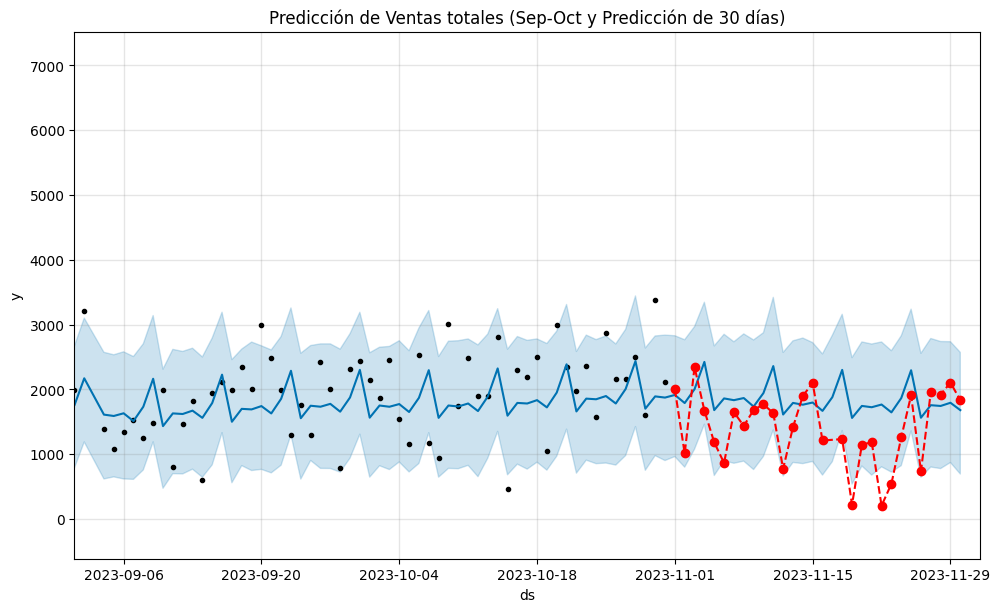

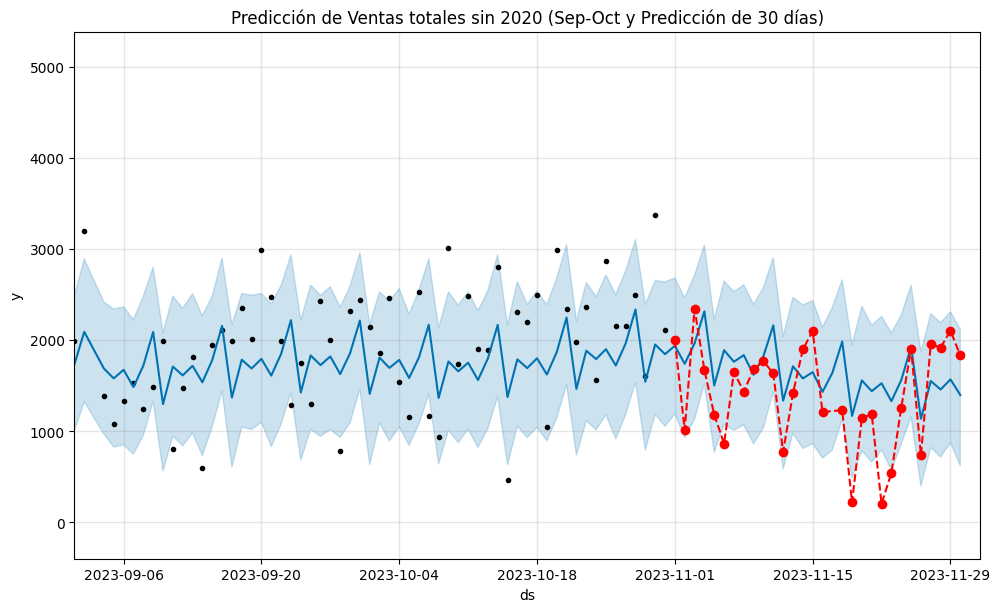

prediccion con todos los valores               ds      yhat
1698 2023-11-01 1913.2945
1699 2023-11-02 1788.6724
1700 2023-11-03 2002.5331
1701 2023-11-04 2423.0207
1702 2023-11-05 1679.3332
1703 2023-11-06 1859.7831
1704 2023-11-07 1832.8545
1705 2023-11-08 1865.5999
1706 2023-11-09 1734.2384
1707 2023-11-10 1942.4679
1708 2023-11-11 2358.5400
1709 2023-11-12 1611.7315
1710 2023-11-13 1790.4031
1711 2023-11-14 1763.0567
1712 2023-11-15 1796.7320
1713 2023-11-16 1667.6063
1714 2023-11-17 1879.3084
1715 2023-11-18 2299.9961
1716 2023-11-19 1558.8310
1717 2023-11-20 1744.0405
1718 2023-11-21 1723.9795
1719 2023-11-22 1765.5310
1720 2023-11-23 1644.7103
1721 2023-11-24 1864.9831
1722 2023-11-25 2294.3475
1723 2023-11-26 1561.8122
1724 2023-11-27 1755.4624
1725 2023-11-28 1743.5245
1726 2023-11-29 1792.7690
1727 2023-11-30 1679.1171
prediccion sin el 2020               ds      yhat
998  2023-11-01 1938.0934
999  2023-11-02 1740.8432
1000 2023-11-03 1963.4582
1001 2023-11-04 2315.8646
1002 2

In [18]:
# definir las fechas de inicio y fin
fecha_inicio_str = '2023-09-01'
fecha_fin_str = '2023-12-02'
# Convertir las fechas a objetos datetime
fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')

# Crear un modelo de Prophet
modelo1 = Prophet()
modelo2 = Prophet()
# Ajustar el modelo con los datos de entrenamiento
modelo1.fit(df_todo_hasta_nov_prophet)
modelo2.fit(df_todo_hasta_nov_desde_2021_prophet)
# Crear un DataFrame con fechas futuras para hacer la predicción
futuro1 = modelo1.make_future_dataframe(periods=30)
futuro2 = modelo2.make_future_dataframe(periods=30)
# Hacer la predicción
prediccion1 = modelo1.predict(futuro1)
prediccion2 = modelo2.predict(futuro2)

# Visualizar la predicción con límites ajustados
fig = modelo1.plot(prediccion1)

plt.plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas reales de noviembre', color='red', marker='o', linestyle='dashed')

# Aplicar límites al eje x
plt.xlim([fecha_inicio, fecha_fin])
# Añadir título al gráfico
plt.title(f'Predicción de Ventas totales (Sep-Oct y Predicción de 30 días)')
# Mostrar el gráfico
plt.show()

# Visualizar la predicción con límites ajustados
fig = modelo2.plot(prediccion2)

plt.plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas reales de noviembre', color='red', marker='o', linestyle='dashed')

# Aplicar límites al eje x
plt.xlim([fecha_inicio, fecha_fin])
# Añadir título al gráfico
plt.title(f'Predicción de Ventas totales sin 2020 (Sep-Oct y Predicción de 30 días)')
# Mostrar el gráfico
plt.show()


# Extraer los valores reales de predicción para cada día
valores_prediccion1 = prediccion1[['ds', 'yhat']].tail(30)
valores_prediccion2 = prediccion2[['ds', 'yhat']].tail(30)

# Mostrar el DataFrame con los valores de predicción
print("prediccion con todos los valores " , valores_prediccion1)
print("prediccion sin el 2020 " , valores_prediccion2)
# # Visualizar la predicción
# fig = modelo1.plot(prediccion1)
# plt.show()

# fig = modelo2.plot(prediccion2)
# plt.show()

## EVALUACION

evaluacion con todos los datos


In [19]:
df_noviembre_sumaT = df_noviembre[[
                                    'FechaMovimiento',
                                    'MontoBase',
                                    ]]
df_noviembre_sumaT = df_noviembre_sumaT.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

print(df_noviembre_sumaT.head(10))
print(df_noviembre_sumaT.dtypes)
print(df_noviembre_sumaT.shape)



  FechaMovimiento  MontoBase
0      2023-11-01  1999.7321
1      2023-11-02  1011.2892
2      2023-11-03  2343.7883
3      2023-11-04  1673.2089
4      2023-11-05  1181.9289
5      2023-11-06   863.7984
6      2023-11-07  1648.4580
7      2023-11-08  1434.6711
8      2023-11-09  1680.6493
9      2023-11-10  1767.7892
FechaMovimiento     object
MontoBase          float64
dtype: object
(29, 2)


### Revisar si noviembre no tiene espacios vacios


In [20]:
if len(df_noviembre_sumaT) < 30:
    # Crear un rango de fechas de noviembre
    fechas_noviembre = pd.date_range(start='2023-11-01', end='2023-11-30', freq='D')

    # Convertir la columna 'FechaMovimiento' a tipo datetime64[ns]
    df_noviembre_sumaT['FechaMovimiento'] = pd.to_datetime(df_noviembre_sumaT['FechaMovimiento'])

    # Crear un DataFrame con todas las fechas de noviembre
    todas_las_fechas = pd.DataFrame({'FechaMovimiento': fechas_noviembre})

    # Merge para obtener las fechas faltantes
    df_noviembre_sumaT = todas_las_fechas.merge(df_noviembre_sumaT, on='FechaMovimiento', how='left')

    # Llenar los valores faltantes con 0
    df_noviembre_sumaT['MontoBase'].fillna(0, inplace=True)

    # Convertir la columna 'FechaMovimiento' a tipo datetime64[ns] sin tiempo
    df_noviembre_sumaT['FechaMovimiento'] = pd.to_datetime(df_noviembre_sumaT['FechaMovimiento'].dt.date)

    # Ordenar el DataFrame por fecha
    df_noviembre_sumaT.sort_values(by='FechaMovimiento', inplace=True)

# Asegurarse de que la longitud sea exactamente 30
assert len(df_noviembre_sumaT) == 30, "¡Error! El DataFrame no tiene 30 días."

# Imprimir el DataFrame resultante
print(df_noviembre_sumaT)

   FechaMovimiento  MontoBase
0       2023-11-01  1999.7321
1       2023-11-02  1011.2892
2       2023-11-03  2343.7883
3       2023-11-04  1673.2089
4       2023-11-05  1181.9289
5       2023-11-06   863.7984
6       2023-11-07  1648.4580
7       2023-11-08  1434.6711
8       2023-11-09  1680.6493
9       2023-11-10  1767.7892
10      2023-11-11  1634.3693
11      2023-11-12   773.2943
12      2023-11-13  1415.9722
13      2023-11-14  1897.6758
14      2023-11-15  2099.2341
15      2023-11-16  1211.0052
16      2023-11-17     0.0000
17      2023-11-18  1232.0448
18      2023-11-19   220.6310
19      2023-11-20  1145.2787
20      2023-11-21  1184.8036
21      2023-11-22   204.6555
22      2023-11-23   543.1047
23      2023-11-24  1259.1186
24      2023-11-25  1906.8695
25      2023-11-26   736.9200
26      2023-11-27  1955.9174
27      2023-11-28  1918.5018
28      2023-11-29  2103.6930
29      2023-11-30  1831.7624


In [21]:
# print(df_noviembre_sumaT.dtypes)

copiar el dataframe de noviembre

In [22]:
df_noviembre_desde_2021 = df_noviembre_sumaT.copy()

In [23]:
# Convertir las columnas de fecha a tipo datetime
df_noviembre_sumaT['FechaMovimiento'] = pd.to_datetime(df_noviembre_sumaT['FechaMovimiento'])
valores_prediccion1['ds'] = pd.to_datetime(valores_prediccion1['ds'])

# Fusionar los DataFrames en base a la columna de fecha
df_noviembre_sumaT = pd.merge(df_noviembre_sumaT, valores_prediccion1[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

# Renombrar la columna yhat a Ventas_PROPHET
df_noviembre_sumaT.rename(columns={'yhat': 'Ventas_PROPHET'}, inplace=True)

# Opcional: Eliminar la columna adicional 'ds' si no la necesitas
df_noviembre_sumaT.drop(columns=['ds'], inplace=True)

# Imprimir el resultado
print(df_noviembre_sumaT.head(50))

   FechaMovimiento  MontoBase  Ventas_PROPHET
0       2023-11-01  1999.7321       1913.2945
1       2023-11-02  1011.2892       1788.6724
2       2023-11-03  2343.7883       2002.5331
3       2023-11-04  1673.2089       2423.0207
4       2023-11-05  1181.9289       1679.3332
5       2023-11-06   863.7984       1859.7831
6       2023-11-07  1648.4580       1832.8545
7       2023-11-08  1434.6711       1865.5999
8       2023-11-09  1680.6493       1734.2384
9       2023-11-10  1767.7892       1942.4679
10      2023-11-11  1634.3693       2358.5400
11      2023-11-12   773.2943       1611.7315
12      2023-11-13  1415.9722       1790.4031
13      2023-11-14  1897.6758       1763.0567
14      2023-11-15  2099.2341       1796.7320
15      2023-11-16  1211.0052       1667.6063
16      2023-11-17     0.0000       1879.3084
17      2023-11-18  1232.0448       2299.9961
18      2023-11-19   220.6310       1558.8310
19      2023-11-20  1145.2787       1744.0405
20      2023-11-21  1184.8036     

In [24]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_PROPHET'])

Evaluation metric results:  
MSE is : 553976.3144819281
MAE is : 595.524865016847
R2 is : -0.5252623492894297 %
------------------------------
MRSE is : 744.2958514474793
MAPE is : 88.62104810873046 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




evaluacion sin 2020

In [25]:
# Convertir las columnas de fecha a tipo datetime
df_noviembre_desde_2021['FechaMovimiento'] = pd.to_datetime(df_noviembre_desde_2021['FechaMovimiento'])
valores_prediccion2['ds'] = pd.to_datetime(valores_prediccion2['ds'])

# Fusionar los DataFrames en base a la columna de fecha
df_noviembre_desde_2021 = pd.merge(df_noviembre_desde_2021, valores_prediccion2[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

# Renombrar la columna yhat a Ventas_PROPHET
df_noviembre_desde_2021.rename(columns={'yhat': 'Ventas_PROPHET'}, inplace=True)

# Opcional: Eliminar la columna adicional 'ds' si no la necesitas
df_noviembre_desde_2021.drop(columns=['ds'], inplace=True)

# Imprimir el resultado
print(df_noviembre_desde_2021.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET
0       2023-11-01  1999.7321       1938.0934
1       2023-11-02  1011.2892       1740.8432
2       2023-11-03  2343.7883       1963.4582
3       2023-11-04  1673.2089       2315.8646
4       2023-11-05  1181.9289       1502.5276
5       2023-11-06   863.7984       1889.2897
6       2023-11-07  1648.4580       1762.6734
7       2023-11-08  1434.6711       1835.1293
8       2023-11-09  1680.6493       1619.1114
9       2023-11-10  1767.7892       1824.6313
10      2023-11-11  1634.3693       2162.0183
11      2023-11-12   773.2943       1336.0989
12      2023-11-13  1415.9722       1713.0265
13      2023-11-14  1897.6758       1579.5766
14      2023-11-15  2099.2341       1648.3889
15      2023-11-16  1211.0052       1432.0375
16      2023-11-17     0.0000       1640.5829
17      2023-11-18  1232.0448       1984.3302
18      2023-11-19   220.6310       1168.0099
19      2023-11-20  1145.2787       1557.6097


In [26]:
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_PROPHET'])

Evaluation metric results:  
MSE is : 377498.3506497769
MAE is : 494.8538132851315
R2 is : -0.03936577451588308 %
------------------------------
MRSE is : 614.4089441485833
MAPE is : 69.37954756974636 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




# LSTM


In [27]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [28]:
print(df_todo_hasta_nov.head())
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov.shape)
print("---"*5, "  PROPHET  ", "---"*5)
print(df_todo_hasta_nov_prophet.head())
print(df_todo_hasta_nov_prophet.dtypes)
print(df_todo_hasta_nov_prophet.shape)

  FechaMovimiento  NombreProducto  MontoBase   year
0      2018-11-01  POLLO ESPECIAL  1140.6240  26234
1      2018-11-02  POLLO ESPECIAL  1645.2540  58522
2      2018-11-03  POLLO ESPECIAL   712.9790  16144
3      2018-11-04  POLLO ESPECIAL  1343.6330  50450
4      2018-11-05  POLLO ESPECIAL  1755.2580  70630
FechaMovimiento     object
NombreProducto      object
MontoBase          float64
year                 int64
dtype: object
(1698, 4)
---------------   PROPHET   ---------------
           ds         y
0  2018-11-01 1140.6240
1  2018-11-02 1645.2540
2  2018-11-03  712.9790
3  2018-11-04 1343.6330
4  2018-11-05 1755.2580
ds     object
y     float64
dtype: object
(1698, 2)


In [29]:
df_lstm = df_todo_hasta_nov_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })

df_lstm_desde_2021 = df_todo_hasta_nov_desde_2021_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })

In [30]:
# Seleccionar las columnas relevantes y convertir 'FechaMovimiento' a tipo datetime
df_lstm = df_lstm[['FechaMovimiento', 'MontoBase']]
df_lstm['FechaMovimiento'] = pd.to_datetime(df_lstm['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_lstm.set_index('FechaMovimiento', inplace=True)

# Preprocesamiento de fechas utilizando el índice
df_lstm['DayOW'] = df_lstm.index.dayofweek
df_lstm['Month'] = df_lstm.index.month
df_lstm['Year'] = df_lstm.index.year

# Ordenar el DataFrame por la fecha
df_lstm.sort_index(inplace=True)

# Muestra el DataFrame resultante
print(df_lstm)

                 MontoBase  DayOW  Month  Year
FechaMovimiento                               
2018-11-01       1140.6240      3     11  2018
2018-11-02       1645.2540      4     11  2018
2018-11-03        712.9790      5     11  2018
2018-11-04       1343.6330      6     11  2018
2018-11-05       1755.2580      0     11  2018
...                    ...    ...    ...   ...
2023-10-27       2152.1624      4     10  2023
2023-10-28       2499.2891      5     10  2023
2023-10-29       1611.2471      6     10  2023
2023-10-30       3372.2990      0     10  2023
2023-10-31       2112.0323      1     10  2023

[1698 rows x 4 columns]


In [31]:
print(df_lstm)
print(df_lstm.dtypes)
print(df_todo_hasta_nov_prophet)
print(df_todo_hasta_nov_prophet.dtypes)

                 MontoBase  DayOW  Month  Year
FechaMovimiento                               
2018-11-01       1140.6240      3     11  2018
2018-11-02       1645.2540      4     11  2018
2018-11-03        712.9790      5     11  2018
2018-11-04       1343.6330      6     11  2018
2018-11-05       1755.2580      0     11  2018
...                    ...    ...    ...   ...
2023-10-27       2152.1624      4     10  2023
2023-10-28       2499.2891      5     10  2023
2023-10-29       1611.2471      6     10  2023
2023-10-30       3372.2990      0     10  2023
2023-10-31       2112.0323      1     10  2023

[1698 rows x 4 columns]
MontoBase    float64
DayOW          int64
Month          int64
Year           int64
dtype: object
              ds         y
0     2018-11-01 1140.6240
1     2018-11-02 1645.2540
2     2018-11-03  712.9790
3     2018-11-04 1343.6330
4     2018-11-05 1755.2580
...          ...       ...
1693  2023-10-27 2152.1624
1694  2023-10-28 2499.2891
1695  2023-10-29 1611.2

In [32]:
df_lstm.describe()
#df_lstm.head

,MontoBase,DayOW,Month,Year
count,1698.0000,1698.0000,1698.0000,1698.0000
mean,1655.4486,2.8822,6.5654,2020.8751
std,850.5533,1.9638,3.4952,1.4904
min,15.9310,0.0000,1.0000,2018.0000
25%,1103.8447,1.0000,3.0000,2020.0000
50%,1548.6445,3.0000,7.0000,2021.0000
75%,2086.7830,5.0000,10.0000,2022.0000
max,7142.9620,6.0000,12.0000,2023.0000


In [33]:
# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm['MontoBase_scaler'] = scaler.fit_transform(df_lstm['MontoBase'].values.reshape(-1, 1))

# Crear secuencias temporales
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        #label = data[i+seq_length-1]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])

seq_length = 30  # ajusta según tus necesidades
X, y = create_sequences(df_lstm['MontoBase_scaler'].values, seq_length)


dividir en entrenamiento y al final toda la prueba

In [34]:
# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

dividir en periodos de testeo en medio de la serie temporal

In [35]:
# from sklearn.model_selection import TimeSeriesSplit

# tscv = TimeSeriesSplit(n_splits=5)  # Puedes ajustar el número de divisiones

# for train_index, test_index in tscv.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

In [36]:
# Reshape para el modelo LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [37]:
# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

# Hacer predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Desnormalizar las predicciones
predictions = scaler.inverse_transform(predictions)


Epoch 1/50
42/42 - 3s - loss: 0.0200 - 3s/epoch - 77ms/step
Epoch 2/50
42/42 - 1s - loss: 0.0103 - 716ms/epoch - 17ms/step
Epoch 3/50
42/42 - 1s - loss: 0.0100 - 738ms/epoch - 18ms/step
Epoch 4/50
42/42 - 1s - loss: 0.0099 - 510ms/epoch - 12ms/step
Epoch 5/50
42/42 - 0s - loss: 0.0098 - 463ms/epoch - 11ms/step
Epoch 6/50
42/42 - 0s - loss: 0.0098 - 452ms/epoch - 11ms/step
Epoch 7/50
42/42 - 0s - loss: 0.0097 - 468ms/epoch - 11ms/step
Epoch 8/50
42/42 - 0s - loss: 0.0097 - 466ms/epoch - 11ms/step
Epoch 9/50
42/42 - 0s - loss: 0.0096 - 460ms/epoch - 11ms/step
Epoch 10/50
42/42 - 0s - loss: 0.0097 - 437ms/epoch - 10ms/step
Epoch 11/50
42/42 - 0s - loss: 0.0096 - 451ms/epoch - 11ms/step
Epoch 12/50
42/42 - 0s - loss: 0.0096 - 447ms/epoch - 11ms/step
Epoch 13/50
42/42 - 0s - loss: 0.0097 - 439ms/epoch - 10ms/step
Epoch 14/50
42/42 - 0s - loss: 0.0096 - 455ms/epoch - 11ms/step
Epoch 15/50
42/42 - 0s - loss: 0.0096 - 451ms/epoch - 11ms/step
Epoch 16/50
42/42 - 0s - loss: 0.0096 - 462ms/epoch 

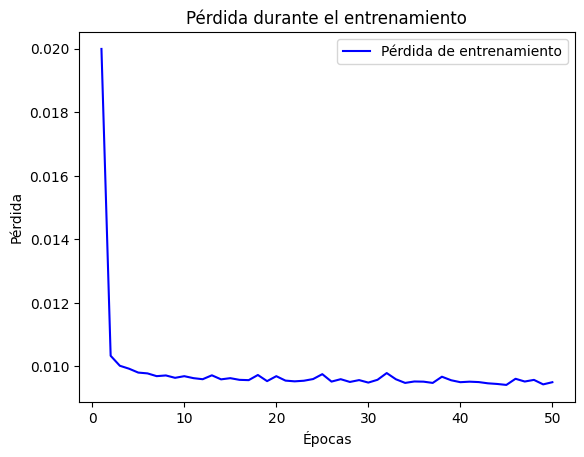

In [38]:
# Recuperar la función de pérdida durante el entrenamiento
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

# Graficar la pérdida durante el entrenamiento
plt.plot(epochs, loss, 'b', label='Pérdida de entrenamiento')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Error cuadrático medio en el conjunto de prueba: 522224.827686858


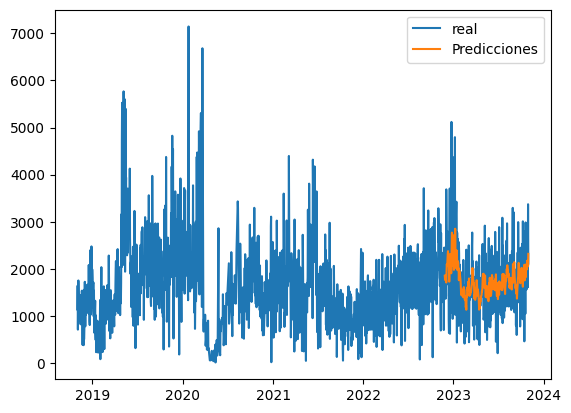

In [39]:
# Calcular el error cuadrático medio en el conjunto de prueba
mse = mean_squared_error(df_lstm['MontoBase'].values[train_size + seq_length : train_size + seq_length + len(predictions)], predictions)
print(f"Error cuadrático medio en el conjunto de prueba: {mse}")

# Visualizar las predicciones
plt.plot(df_lstm['MontoBase'], label='real')
plt.plot(df_lstm.index[train_size+seq_length:], predictions, label='Predicciones')
plt.legend()
plt.show()

In [40]:
# Verificar la forma de los datos
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

Forma de X: (1668, 30)
Forma de y: (1668, 1)


1/1 [==============================] - 0s 34ms/step


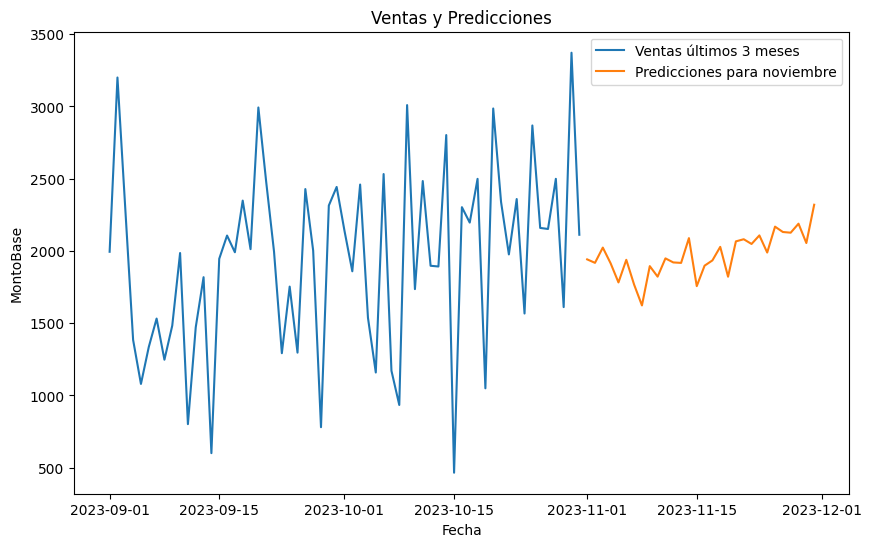

In [41]:
# Supongamos que df_lstm tiene la columna 'FechaMovimiento' como índice
df_lstm.index = pd.to_datetime(df_lstm.index)

# Paso 1: Preparar datos de entrada para las predicciones
last_3_months = df_lstm[df_lstm.index >= '2023-09-01']  # Ajusta la fecha según tu necesidad
last_days = df_lstm.tail(60)  # Últimos 30 días

input_data = last_days['MontoBase'].values
input_data = scaler.transform(input_data.reshape(-1, 1))
input_data, _ = create_sequences(input_data, seq_length)
input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))

# Paso 2: Hacer predicciones para los siguientes 30 días
predictions_future = model.predict(input_data)

# Desnormalizar las predicciones
predictions_future = scaler.inverse_transform(predictions_future)

# Paso 3: Visualizar los resultados
plt.figure(figsize=(10, 6))

# Datos de ventas de los últimos 3 meses
plt.plot(last_3_months.index, last_3_months['MontoBase'], label='Ventas últimos 3 meses')

# Predicciones para noviembre de 2023
dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_future))
plt.plot(dates_future, predictions_future, label='Predicciones para noviembre')

plt.title('Ventas y Predicciones')
plt.xlabel('Fecha')
plt.ylabel('MontoBase')
plt.legend()
plt.show()

In [42]:
# last_3_months.shape
print(predictions_future.shape)

(30, 1)


### Evaluar

In [43]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_sumaT['Ventas_LSTM'] = predictions_future

# Imprimir el resultado
print(df_noviembre_sumaT.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0       2023-11-01  1999.7321       1913.2945    1941.6715
1       2023-11-02  1011.2892       1788.6724    1917.6356
2       2023-11-03  2343.7883       2002.5331    2023.2566
3       2023-11-04  1673.2089       2423.0207    1914.1017
4       2023-11-05  1181.9289       1679.3332    1782.1052
5       2023-11-06   863.7984       1859.7831    1938.5685
6       2023-11-07  1648.4580       1832.8545    1766.6797
7       2023-11-08  1434.6711       1865.5999    1622.8260
8       2023-11-09  1680.6493       1734.2384    1894.8890
9       2023-11-10  1767.7892       1942.4679    1822.0909
10      2023-11-11  1634.3693       2358.5400    1948.5549
11      2023-11-12   773.2943       1611.7315    1920.5389
12      2023-11-13  1415.9722       1790.4031    1917.2373
13      2023-11-14  1897.6758       1763.0567    2088.8252
14      2023-11-15  2099.2341       1796.7320    1756.3519
15      2023-11-16  1211.0052       1667.6063    1898.02

In [44]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])

Evaluation metric results:  
MSE is : 740540.2350501155
MAE is : 662.6514758398439
R2 is : -1.038928577139976 %
------------------------------
MRSE is : 860.54647466021
MAPE is : 105.72054365196703 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




## DESDE 2021

In [45]:
# Seleccionar las columnas relevantes y convertir 'FechaMovimiento' a tipo datetime
df_lstm_desde_2021 = df_lstm_desde_2021[['FechaMovimiento', 'MontoBase']]
df_lstm_desde_2021['FechaMovimiento'] = pd.to_datetime(df_lstm_desde_2021['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_lstm_desde_2021.set_index('FechaMovimiento', inplace=True)

# Preprocesamiento de fechas utilizando el índice
df_lstm_desde_2021['DayOW'] = df_lstm_desde_2021.index.dayofweek
df_lstm_desde_2021['Month'] = df_lstm_desde_2021.index.month
df_lstm_desde_2021['Year'] = df_lstm_desde_2021.index.year

# Ordenar el DataFrame por la fecha
df_lstm_desde_2021.sort_index(inplace=True)

# Muestra el DataFrame resultante
print(df_lstm_desde_2021)

# Normalizar los datos
scaler_2 = MinMaxScaler(feature_range=(0, 1))
df_lstm_desde_2021['MontoBase_scaler'] = scaler_2.fit_transform(df_lstm_desde_2021['MontoBase'].values.reshape(-1, 1))

# Crear secuencias temporales
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        #label = data[i+seq_length-1]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])

seq_length = 30  # ajusta según tus necesidades
X, y = create_sequences(df_lstm_desde_2021['MontoBase_scaler'].values, seq_length)


# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Reshape para el modelo LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Construir el modelo LSTM
model_2 = Sequential()
model_2.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model_2.add(Dense(units=1))
model_2.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history_2 = model_2.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

# Hacer predicciones en el conjunto de prueba
predictions_2 = model_2.predict(X_test)

# Desnormalizar las predicciones
predictions_2 = scaler_2.inverse_transform(predictions_2)


                 MontoBase  DayOW  Month  Year
FechaMovimiento                               
2021-01-02       1822.6310      5      1  2021
2021-01-03        543.4340      6      1  2021
2021-01-04       1221.7920      0      1  2021
2021-01-05       1963.7850      1      1  2021
2021-01-06       1012.1080      2      1  2021
...                    ...    ...    ...   ...
2023-10-27       2152.1624      4     10  2023
2023-10-28       2499.2891      5     10  2023
2023-10-29       1611.2471      6     10  2023
2023-10-30       3372.2990      0     10  2023
2023-10-31       2112.0323      1     10  2023

[998 rows x 4 columns]
Epoch 1/50
25/25 - 3s - loss: 0.0452 - 3s/epoch - 108ms/step
Epoch 2/50
25/25 - 0s - loss: 0.0165 - 268ms/epoch - 11ms/step
Epoch 3/50
25/25 - 0s - loss: 0.0161 - 274ms/epoch - 11ms/step
Epoch 4/50
25/25 - 0s - loss: 0.0161 - 287ms/epoch - 11ms/step
Epoch 5/50
25/25 - 0s - loss: 0.0160 - 280ms/epoch - 11ms/step
Epoch 6/50
25/25 - 0s - loss: 0.0159 - 271ms/epoch -

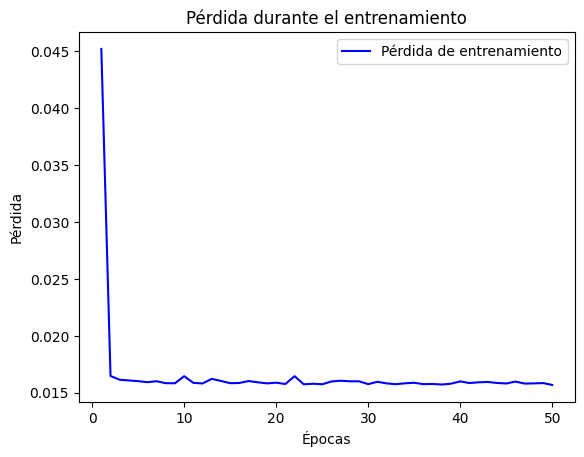

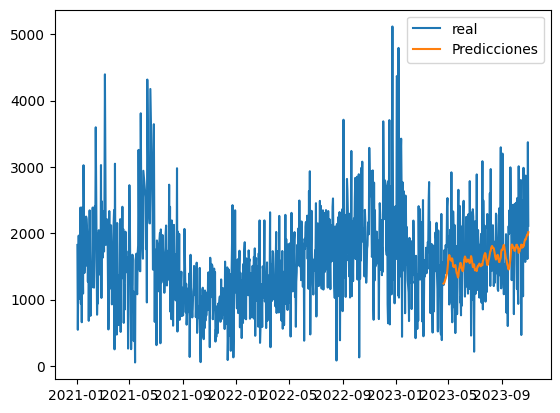

In [46]:
# Recuperar la función de pérdida durante el entrenamiento
loss_2 = history_2.history['loss']
epochs_2 = range(1, len(loss_2) + 1)

# Graficar la pérdida durante el entrenamiento
plt.plot(epochs_2, loss_2, 'b', label='Pérdida de entrenamiento')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


# Visualizar las predicciones
plt.plot(df_lstm_desde_2021['MontoBase'], label='real')
plt.plot(df_lstm_desde_2021.index[train_size+seq_length:], predictions_2, label='Predicciones')
plt.legend()
plt.show()


Forma de X: (968, 30)
Forma de y: (968, 1)
1/1 [==============================] - 0s 28ms/step


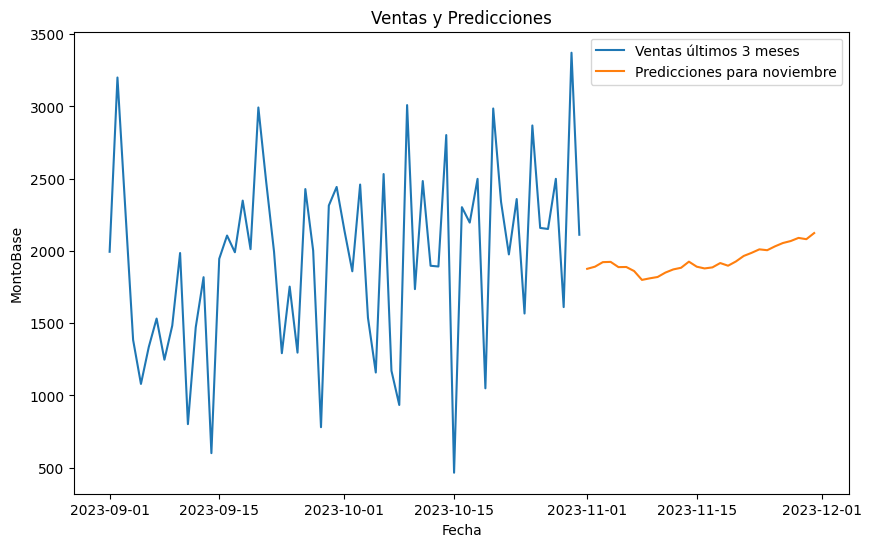

In [47]:
# Verificar la forma de los datos
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

# Supongamos que df_lstm_desde_2021 tiene la columna 'FechaMovimiento' como índice
df_lstm_desde_2021.index = pd.to_datetime(df_lstm_desde_2021.index)

# Paso 1: Preparar datos de entrada para las predicciones
last_3_months = df_lstm[df_lstm.index >= '2023-09-01']  # Ajusta la fecha según tu necesidad
last_days = df_lstm.tail(60)  # Últimos 30 días

input_data = last_days['MontoBase'].values
input_data = scaler.transform(input_data.reshape(-1, 1))
input_data, _ = create_sequences(input_data, seq_length)
input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))

# Paso 2: Hacer predicciones para los siguientes 30 días
predictions_2_future = model_2.predict(input_data)

# Desnormalizar las predicciones
predictions_2_future = scaler.inverse_transform(predictions_2_future)

# Paso 3: Visualizar los resultados
plt.figure(figsize=(10, 6))

# Datos de ventas de los últimos 3 meses
plt.plot(last_3_months.index, last_3_months['MontoBase'], label='Ventas últimos 3 meses')

# Predicciones para noviembre de 2023
dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_2_future))
plt.plot(dates_future, predictions_2_future, label='Predicciones para noviembre')

plt.title('Ventas y Predicciones')
plt.xlabel('Fecha')
plt.ylabel('MontoBase')
plt.legend()
plt.show()

### Evaluar

In [48]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_desde_2021['Ventas_LSTM'] = predictions_2_future

# Imprimir el resultado
print(df_noviembre_sumaT.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0       2023-11-01  1999.7321       1913.2945    1941.6715
1       2023-11-02  1011.2892       1788.6724    1917.6356
2       2023-11-03  2343.7883       2002.5331    2023.2566
3       2023-11-04  1673.2089       2423.0207    1914.1017
4       2023-11-05  1181.9289       1679.3332    1782.1052
5       2023-11-06   863.7984       1859.7831    1938.5685
6       2023-11-07  1648.4580       1832.8545    1766.6797
7       2023-11-08  1434.6711       1865.5999    1622.8260
8       2023-11-09  1680.6493       1734.2384    1894.8890
9       2023-11-10  1767.7892       1942.4679    1822.0909
10      2023-11-11  1634.3693       2358.5400    1948.5549
11      2023-11-12   773.2943       1611.7315    1920.5389
12      2023-11-13  1415.9722       1790.4031    1917.2373
13      2023-11-14  1897.6758       1763.0567    2088.8252
14      2023-11-15  2099.2341       1796.7320    1756.3519
15      2023-11-16  1211.0052       1667.6063    1898.02

In [49]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])

Evaluation metric results:  
MSE is : 740540.2350501155
MAE is : 662.6514758398439
R2 is : -1.038928577139976 %
------------------------------
MRSE is : 860.54647466021
MAPE is : 105.72054365196703 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




# ARIMA

In [50]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.7 MB/s eta 0:00:00


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

from pmdarima.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [52]:
df_todo_hasta_nov_prophet.head()

,ds,y
0,2018-11-01,1140.6240
1,2018-11-02,1645.2540
2,2018-11-03,712.9790
3,2018-11-04,1343.6330
4,2018-11-05,1755.2580


## CON TODOS LOS AÑOS


In [53]:
df_arima = df_todo_hasta_nov_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })


# Establecer la columna 'FechaMovimiento' como índice
df_arima.set_index('FechaMovimiento', inplace=True)
# # Dejar la columna 'FechaMovimiento' como tipo fecha
#df_arima['FechaMovimiento'] = pd.to_datetime(df_arima['FechaMovimiento'])

print(df_arima.dtypes)
print(df_arima.head)

MontoBase    float64
dtype: object
<bound method NDFrame.head of                  MontoBase
FechaMovimiento           
2018-11-01       1140.6240
2018-11-02       1645.2540
2018-11-03        712.9790
2018-11-04       1343.6330
2018-11-05       1755.2580
...                    ...
2023-10-27       2152.1624
2023-10-28       2499.2891
2023-10-29       1611.2471
2023-10-30       3372.2990
2023-10-31       2112.0323

[1698 rows x 1 columns]>


In [54]:
df_arima.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1698 entries, 2018-11-01 to 2023-10-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MontoBase  1698 non-null   float64
dtypes: float64(1)
memory usage: 26.5+ KB


### Identificar si los datos son estacionarios o no


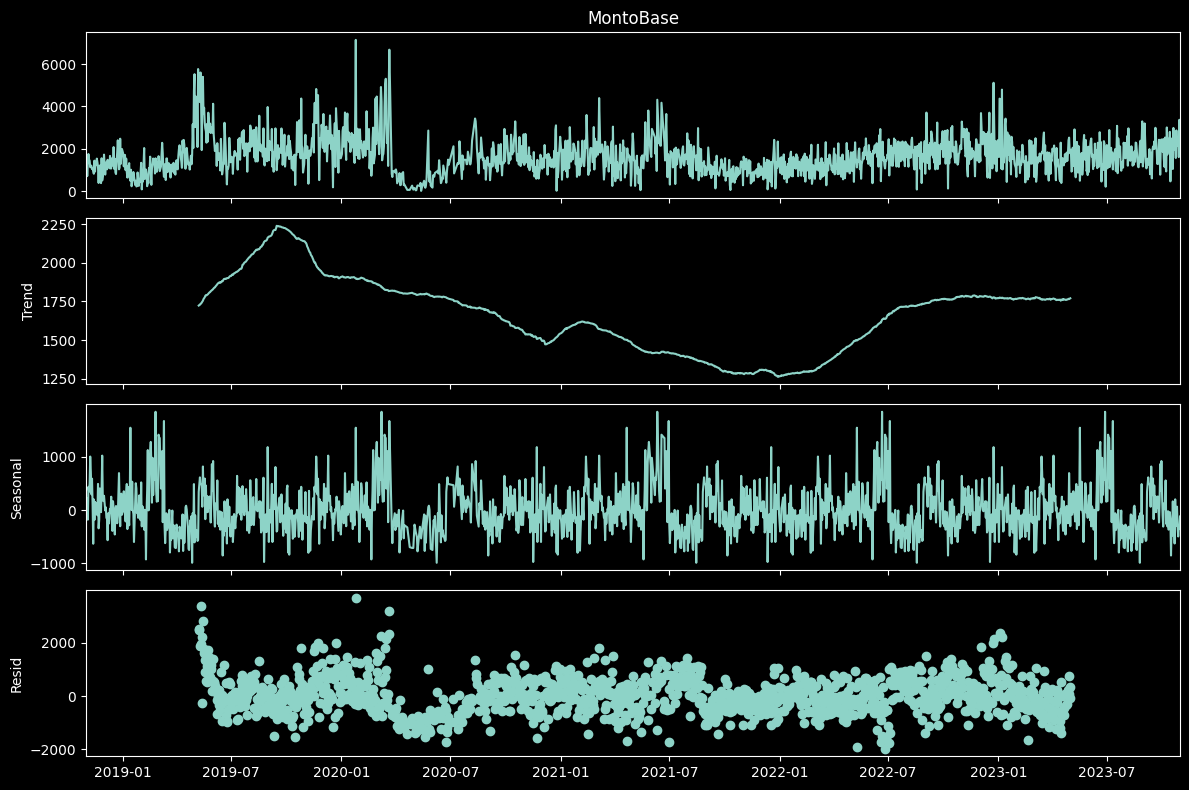

In [55]:
#plt.style.use('seaborn')
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df_arima["MontoBase"], model = "add", period=365)
a.plot();

In [56]:
df_arima

,MontoBase
FechaMovimiento,
2018-11-01,1140.6240
2018-11-02,1645.2540
2018-11-03,712.9790
2018-11-04,1343.6330
2018-11-05,1755.2580
...,...
2023-10-27,2152.1624
2023-10-28,2499.2891
2023-10-29,1611.2471


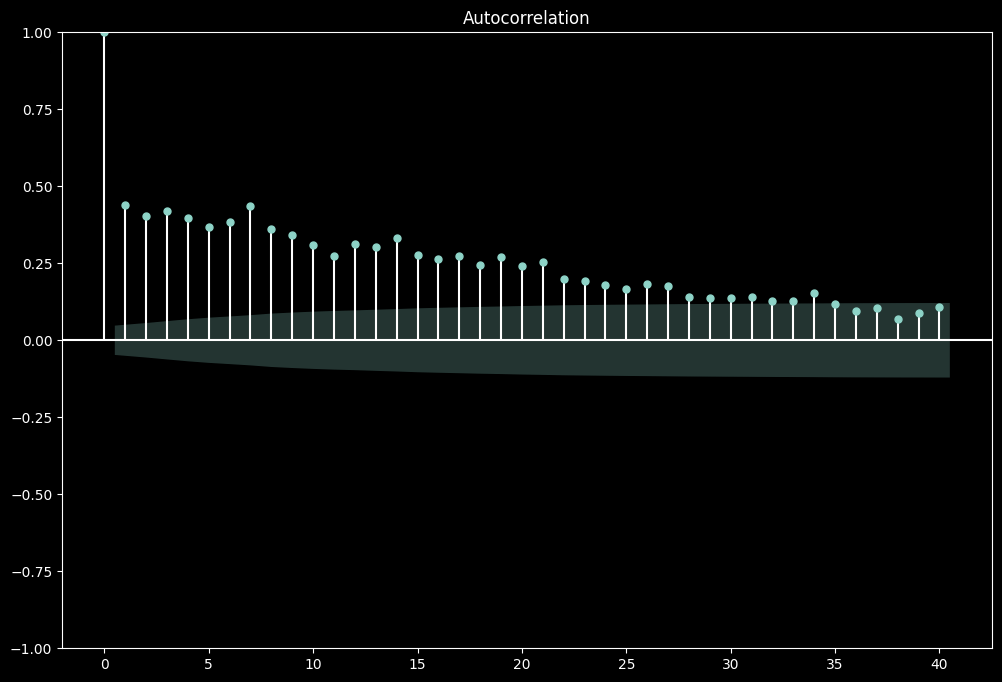

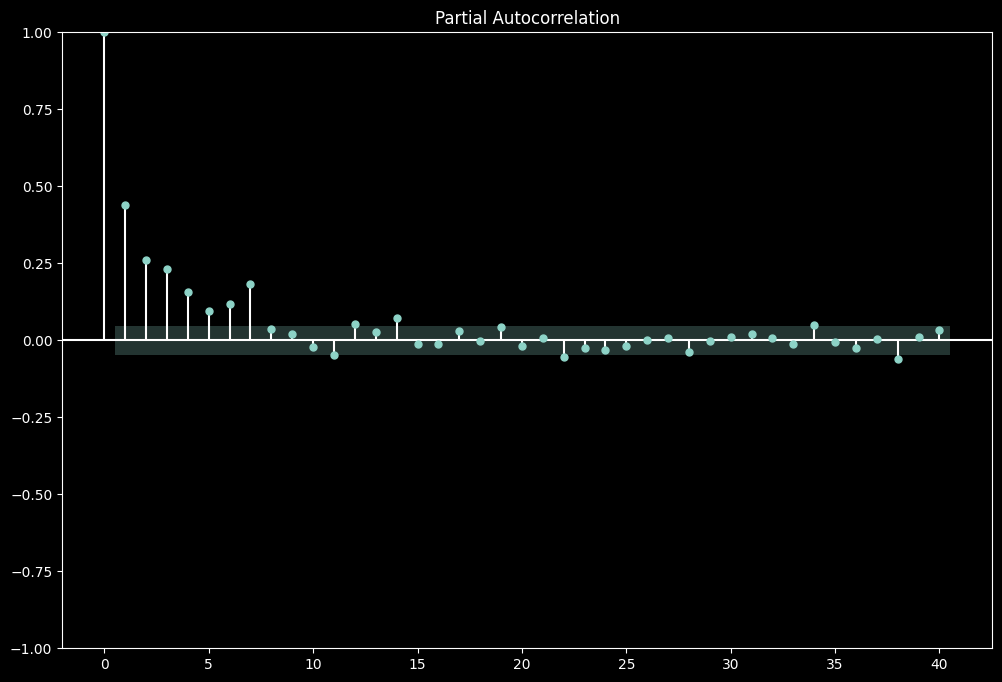

In [57]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
# Dejar la columna 'FechaMovimiento' como tipo fecha
df_arima=df_arima.reset_index()

# Convertir 'FechaMovimiento' a tipo datetime si aún no lo has hecho
df_arima['FechaMovimiento'] = pd.to_datetime(df_arima['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_arima.set_index('FechaMovimiento', inplace=True)

# Visualizar ACF y PACF
plt.style.use('dark_background')
plot_acf(df_arima['MontoBase'], lags=40)
plt.show()

plot_pacf(df_arima['MontoBase'], lags=40)
plt.show()

### prueba de Dickey-Fuller

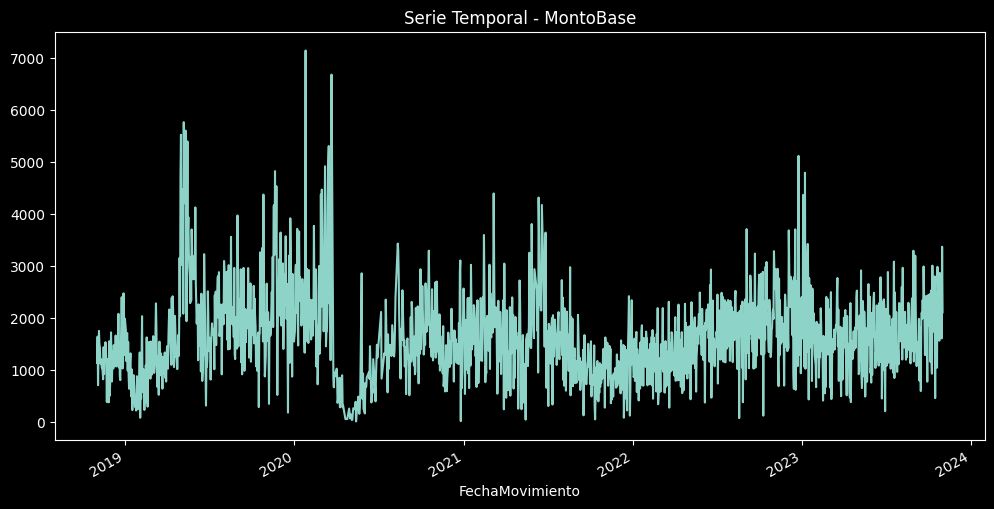

count   1698.0000
mean    1655.4486
std      850.5533
min       15.9310
25%     1103.8447
50%     1548.6445
75%     2086.7830
max     7142.9620
Name: MontoBase, dtype: float64
Estadística de la prueba de Dickey-Fuller: -5.007710951303994
P-valor: 2.142637715984723e-05
Valores críticos: {'1%': -3.434239130607915, '5%': -2.8632578315742134, '10%': -2.5676845297222424}


In [58]:
# 1. Visualización de la Serie Temporal
df_arima['MontoBase'].plot(figsize=(12, 6))
plt.title('Serie Temporal - MontoBase')
plt.show()

# 2. Estadísticas Descriptivas
print(df_arima['MontoBase'].describe())

# 3. Prueba de Dickey-Fuller
result = adfuller(df_arima['MontoBase'])
print(f'Estadística de la prueba de Dickey-Fuller: {result[0]}')
print(f'P-valor: {result[1]}')
print(f'Valores críticos: {result[4]}')

In [59]:
def Prueba_Dickey_Fuller(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos no son estacionarios")

In [60]:
Prueba_Dickey_Fuller(df_arima["MontoBase"],"MontoBase")

Resultados de la prueba de Dickey-Fuller para columna: MontoBase
Test Statistic                         -5.0077
p-value                                 0.0000
No Lags Used                           13.0000
Número de observaciones utilizadas   1684.0000
Critical Value (1%)                    -3.4342
Critical Value (5%)                    -2.8633
Critical Value (10%)                   -2.5677
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios


### Dividir en train y test

In [61]:
# # dividir en orden cronologico, un 80% para entrenamiento
# train_size = int(len(df_arima) * 0.8)
# train, test = df_arima[0:train_size], df_arima[train_size:]


# dividir en orden cronologico, entrenando sin el mes de octubre
train_size = int(len(df_arima) - 31)
train, test = df_arima[0:train_size], df_arima[train_size:]

# Divide los datos en entrenamiento y prueba
# # Asegúrate de tener una columna de fecha (DatetimeIndex) en tu DataFrame
# y = df_arima['MontoBase']

# # Especifica el tamaño del conjunto de entrenamiento
# train_size = len(y) - 30

# # Divide los datos en entrenamiento y prueba
# train, test = train_test_split(y, train_size=train_size)


In [62]:
train.shape, test.shape

((1667, 1), (31, 1))

### más pruebas


In [63]:
display(df_arima.head(10))
#df_arima = df_arima.set_index('FechaMovimiento')
df_arima = df_arima.asfreq('D')
display(df_arima.head(10))
#df_arima = df_arima.asfreq(None)

,MontoBase
FechaMovimiento,
2018-11-01,1140.6240
2018-11-02,1645.2540
2018-11-03,712.9790
2018-11-04,1343.6330
2018-11-05,1755.2580
2018-11-06,1496.7130
2018-11-07,1442.1560
2018-11-08,1129.0540
2018-11-09,1214.9390


,MontoBase
FechaMovimiento,
2018-11-01,1140.6240
2018-11-02,1645.2540
2018-11-03,712.9790
2018-11-04,1343.6330
2018-11-05,1755.2580
2018-11-06,1496.7130
2018-11-07,1442.1560
2018-11-08,1129.0540
2018-11-09,1214.9390


In [64]:
print(df_arima.isnull().sum())

MontoBase    128
dtype: int64


In [65]:
df_arima = df_arima.dropna()

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -5.007710951303994, p-value: 2.142637715984723e-05
KPSS Statistic: 0.27628125982219287, p-value: 0.1

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -16.624362123379765, p-value: 1.687233380934886e-29
KPSS Statistic: 0.05686643976450341, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -16.32244959430457, p-value: 3.117960213243601e-29
KPSS Statistic: 0.12633915639068355, p-value: 0.1


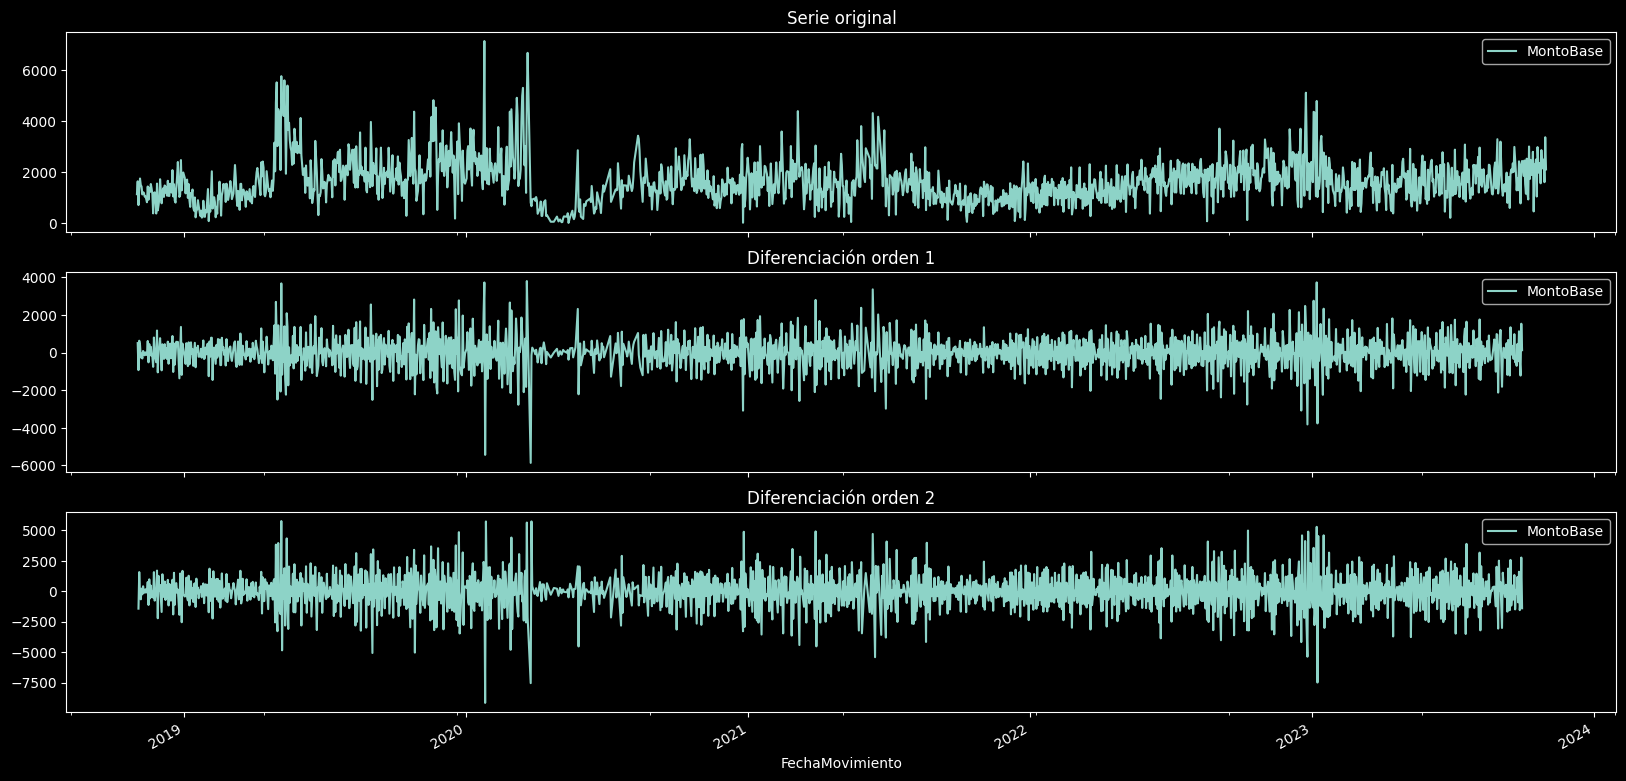

In [66]:

from statsmodels.tsa.stattools import kpss
import warnings
# Test estacionariedad
# ==============================================================================
warnings.filterwarnings("ignore")

df_arima_diff_1 = train.diff().dropna()
df_arima_diff_2 = df_arima_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(df_arima)
kpss_result = kpss(df_arima)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(df_arima_diff_1)
kpss_result = kpss(df_arima.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(df_arima_diff_2)
kpss_result = kpss(df_arima.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 10), sharex=True)
df_arima.plot(ax=axs[0], title='Serie original')
df_arima_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
df_arima_diff_2.plot(ax=axs[2], title='Diferenciación orden 2');

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


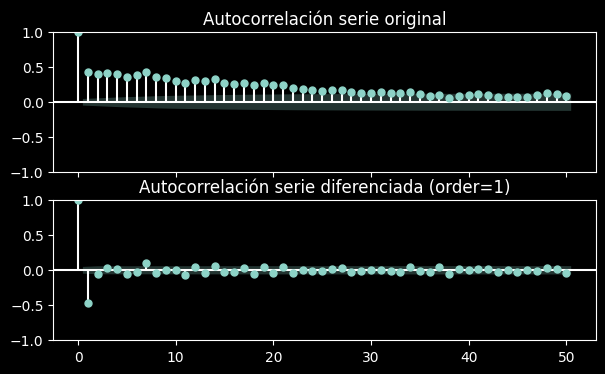

In [67]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(df_arima, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(df_arima_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)');

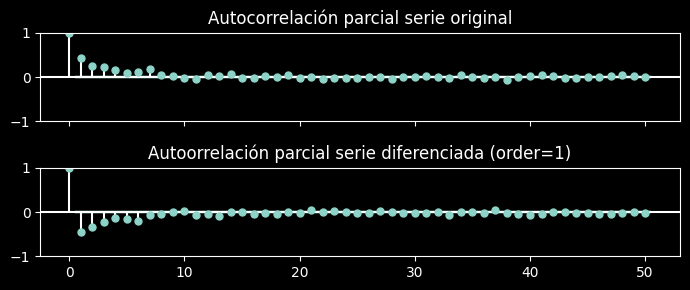

In [68]:
# Autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
plot_pacf(df_arima, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(df_arima_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)');
plt.tight_layout();

In [69]:
# # Asegurarse de que df_arima sea una serie temporal y no un DataFrame
# #df_arima = df_arima['MontoBase']

# # Descomposición de la serie original
# res_decompose = seasonal_decompose(df_arima, model='additive', extrapolate_trend='freq', period=365)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
# # Descomposición de la serie original y la serie diferenciada
# # ==============================================================================
# #res_decompose = seasonal_decompose(df_arima, model='additive', extrapolate_trend='freq')

# res_descompose_diff_2 = seasonal_decompose(df_arima_diff_1, model='additive', extrapolate_trend='freq', period=365)

# fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
# res_decompose.observed.plot(ax=axs[0, 0])
# axs[0, 0].set_title('Serie original')
# res_decompose.trend.plot(ax=axs[1, 0])
# axs[1, 0].set_title('Tendencia')
# res_decompose.seasonal.plot(ax=axs[2, 0])
# axs[2, 0].set_title('Estacionalidad')
# res_decompose.resid.plot(ax=axs[3, 0])
# axs[3, 0].set_title('Residuos')
# res_descompose_diff_2.observed.plot(ax=axs[0, 1])
# axs[0, 1].set_title('Series diferenciadas (order=1)')
# res_descompose_diff_2.trend.plot(ax=axs[1, 1])
# axs[1, 1].set_title('Tendencia')
# res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
# axs[2, 1].set_title('Estacionalidad')
# res_descompose_diff_2.resid.plot(ax=axs[3, 1])
# axs[3, 1].set_title('Residuos')
# fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
# fig.tight_layout();

In [71]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
df_arima_diff_1_12 = train.diff().diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(df_arima_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(df_arima_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -12.700364473399702, p-value: 1.0832351898279091e-23
KPSS Statistic: 0.027373019618702647, p-value: 0.1


### auto_arima


In [72]:
# # Modelo Auto-Arima
# from pmdarima import auto_arima

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
# # posibles valores para m = 7_diarios, 12_mensuales, 52_semanales
# modelo_auto=auto_arima(train,start_p=0,d=1,start_q=0,
#           max_p=4,max_d=2,max_q=4, start_P=0,
#           D=1, start_Q=0, max_P=2,max_D=1,
#           max_Q=2, m=12, seasonal=True,
#           error_action='warn',trace=True,
#           supress_warnings=True,stepwise=True,
#           random_state=20,n_fits=50)
# print(modelo_auto)
# # ## se tiene el problema de q se usa toda la memoria RAM 12.7GB cuando se tiene m=365 (supuestamente periodos anuales)

In [74]:
# print(modelo_auto.summary())

### implementación del modelo

In [75]:
print(train)

                 MontoBase
FechaMovimiento           
2018-11-01       1140.6240
2018-11-02       1645.2540
2018-11-03        712.9790
2018-11-04       1343.6330
2018-11-05       1755.2580
...                    ...
2023-09-26       2428.3650
2023-09-27       2002.2241
2023-09-28        779.7913
2023-09-29       2314.3827
2023-09-30       2443.0856

[1667 rows x 1 columns]


In [76]:
# plt.style.use('seaborn')
# modelo_auto.plot_diagnostics(figsize=(20,8))
# plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
# arima_model = SARIMAX(train["MontoBase"], order = (4,1,1), seasonal_order = (2,1,0,12)) # primerasucursal
arima_model = SARIMAX(train["MontoBase"], order = (0,1,2), seasonal_order = (2,1,0,12))
arima_result = arima_model.fit()
warnings.filterwarnings("default")
arima_result.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/usr/local/lib/python3.10/dist-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/usr/local/lib/python3.10/dist-packages/pandas/core/reshape/ut

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           MontoBase   No. Observations:                 1667
Model:             SARIMAX(0, 1, 2)x(2, 1, [], 12)   Log Likelihood              -13450.147
Date:                             Sat, 02 Mar 2024   AIC                          26910.295
Time:                                     04:49:26   BIC                          26937.350
Sample:                                          0   HQIC                         26920.324
                                            - 1667                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7746      0.018    -41.989      0.000      -0.811      -0.738
ma.L2         -0.0398      0.018     -2.188      0.029      -0.075      -0.004
ar.S.L12      -0.6339      0.018    -34.850      0.000      -0.670      -0.598
ar.S.L24      -0.3225      0.020    -16.055      0.000      -0.362      -0.283
sigma2      6.759e+05   1.64e+04     41.296      0.000    6.44e+05    7.08e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               455.28
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Cómo interpretar las gráficas de residuos en el modelo ARIMA


In [78]:
arima_pred = arima_result.predict(start = len(train), end = len(df_arima)-1, typ="levels").rename("ARIMA_Predictions")
arima_pred

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['ty

1667   2174.9687
1668   2499.4264
1669   2056.7894
1670   2353.8074
1671   2032.7802
1672   1724.4954
1673   1786.1712
1674   1966.6128
1675   2618.6589
1676   1635.4433
1677   2062.9496
1678   2303.7958
1679   2164.5185
1680   2496.8918
1681   2250.5715
1682   2371.0152
1683   1652.4710
1684   1899.4620
1685   1891.4529
1686   1917.3453
1687   2457.2378
1688   1768.4814
1689   2365.6231
1690   2609.1546
1691   2366.2845
1692   2905.3026
1693   2511.1468
1694   2492.0834
1695   1902.2738
1696   2045.3746
1697   1914.2316
Name: ARIMA_Predictions, dtype: float64

In [79]:
arima_pred.index = test.index

# Ahora puedes ver las predicciones con el índice correcto
print(arima_pred)

FechaMovimiento
2023-10-01   2174.9687
2023-10-02   2499.4264
2023-10-03   2056.7894
2023-10-04   2353.8074
2023-10-05   2032.7802
2023-10-06   1724.4954
2023-10-07   1786.1712
2023-10-08   1966.6128
2023-10-09   2618.6589
2023-10-10   1635.4433
2023-10-11   2062.9496
2023-10-12   2303.7958
2023-10-13   2164.5185
2023-10-14   2496.8918
2023-10-15   2250.5715
2023-10-16   2371.0152
2023-10-17   1652.4710
2023-10-18   1899.4620
2023-10-19   1891.4529
2023-10-20   1917.3453
2023-10-21   2457.2378
2023-10-22   1768.4814
2023-10-23   2365.6231
2023-10-24   2609.1546
2023-10-25   2366.2845
2023-10-26   2905.3026
2023-10-27   2511.1468
2023-10-28   2492.0834
2023-10-29   1902.2738
2023-10-30   2045.3746
2023-10-31   1914.2316
Name: ARIMA_Predictions, dtype: float64


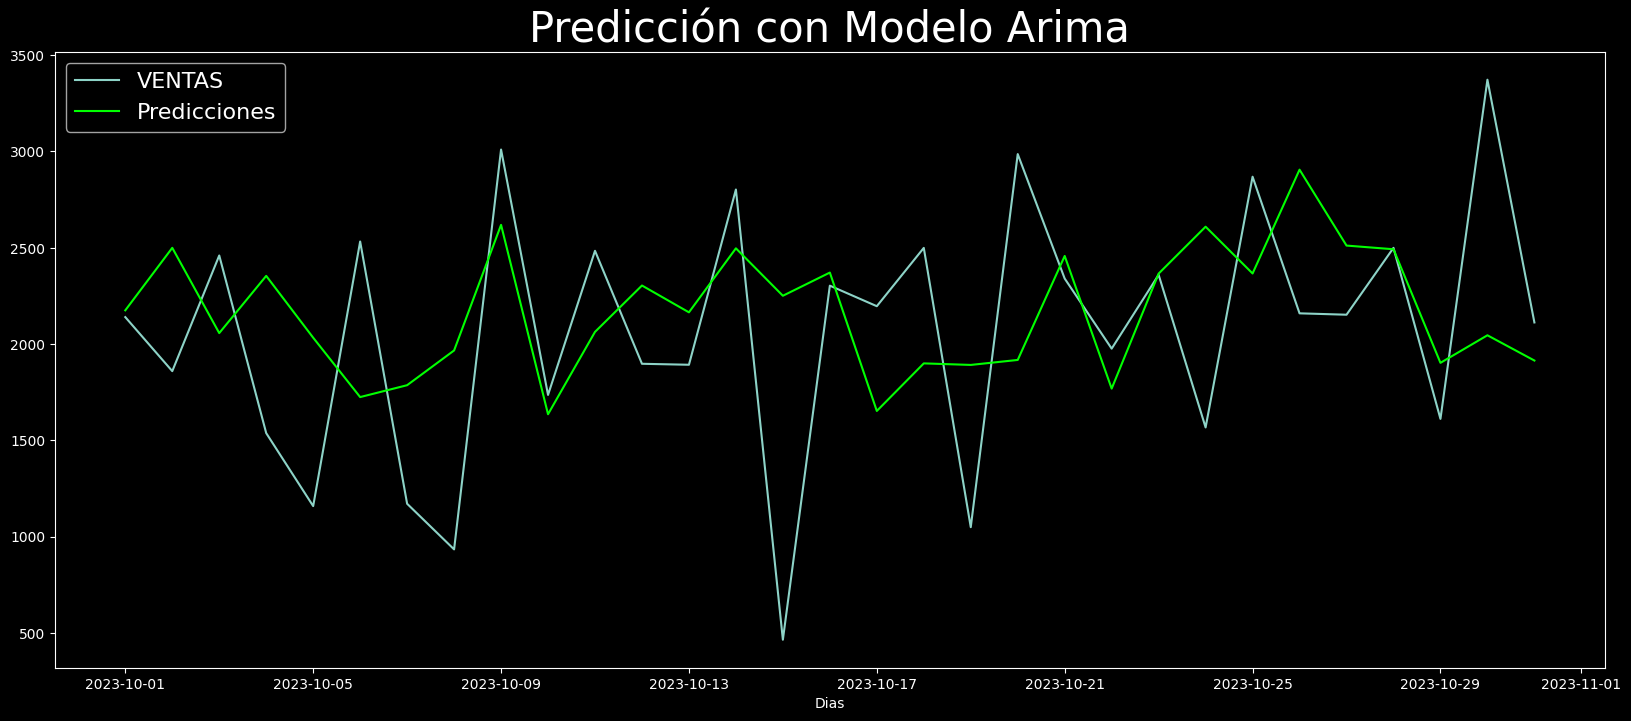

In [80]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(test["MontoBase"], label="VENTAS")
plt.plot(arima_pred, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Dias')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

In [81]:
arima_pred2 = arima_result.predict(start = len(df_arima) ,end=len(df_arima)+29, typ="levels").rename("ARIMA Predictions")
arima_pred2
# start = 1699,end=1728 # en primera sucursal
# start = 1667,end=1697 # en segunda sucursal

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['ty

1698   2345.0586
1699   2608.3647
1700   1655.8129
1701   2502.4222
1702   2708.0890
1703   2489.3392
1704   2894.8140
1705   2531.0644
1706   2657.3731
1707   2114.1456
1708   2144.0436
1709   2113.4255
1710   2337.4041
1711   2812.2023
1712   1931.9154
1713   2565.6869
1714   2794.4900
1715   2593.8557
1716   3017.3467
1717   2681.9948
1718   2761.1395
1719   2146.8713
1720   2282.0289
1721   2227.3954
1722   2451.9158
1723   2881.8405
1724   2040.8107
1725   2729.0536
1726   2955.4009
1727   2735.5053
Name: ARIMA Predictions, dtype: float64

In [82]:
print(df_noviembre_sumaT.head())
#df_noviembre_sumaT.set_index('FechaMovimiento', inplace=True)
print(df_noviembre_sumaT.head())

  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0      2023-11-01  1999.7321       1913.2945    1941.6715
1      2023-11-02  1011.2892       1788.6724    1917.6356
2      2023-11-03  2343.7883       2002.5331    2023.2566
3      2023-11-04  1673.2089       2423.0207    1914.1017
4      2023-11-05  1181.9289       1679.3332    1782.1052
  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0      2023-11-01  1999.7321       1913.2945    1941.6715
1      2023-11-02  1011.2892       1788.6724    1917.6356
2      2023-11-03  2343.7883       2002.5331    2023.2566
3      2023-11-04  1673.2089       2423.0207    1914.1017
4      2023-11-05  1181.9289       1679.3332    1782.1052


In [83]:
arima_pred2.index = df_noviembre_sumaT.index

# Ahora puedes ver las predicciones con el índice correcto
print(arima_pred2)

0    2345.0586
1    2608.3647
2    1655.8129
3    2502.4222
4    2708.0890
5    2489.3392
6    2894.8140
7    2531.0644
8    2657.3731
9    2114.1456
10   2144.0436
11   2113.4255
12   2337.4041
13   2812.2023
14   1931.9154
15   2565.6869
16   2794.4900
17   2593.8557
18   3017.3467
19   2681.9948
20   2761.1395
21   2146.8713
22   2282.0289
23   2227.3954
24   2451.9158
25   2881.8405
26   2040.8107
27   2729.0536
28   2955.4009
29   2735.5053
Name: ARIMA Predictions, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<ipython-input-84-2a97b7cdadf6>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


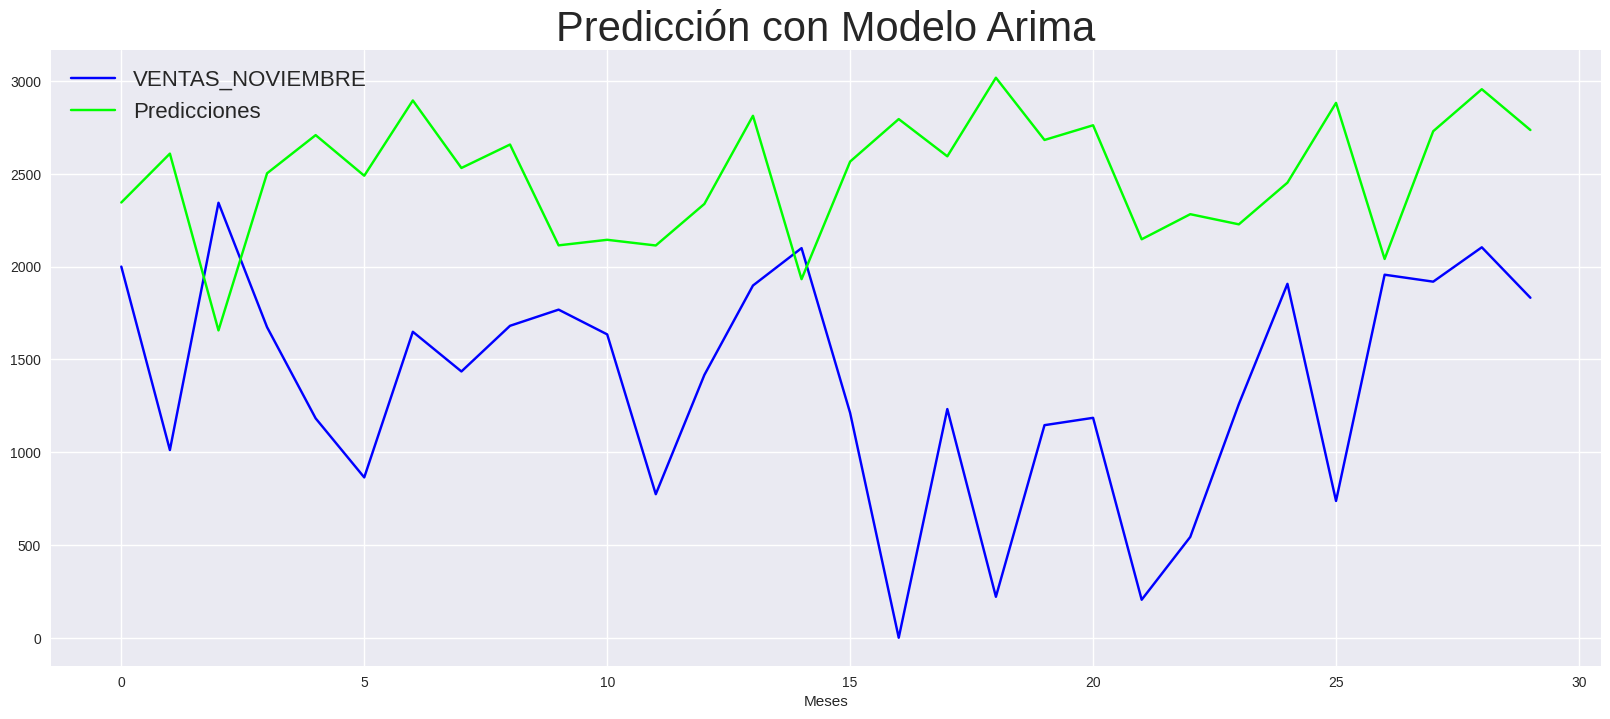

In [84]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)

#plt.plot(test["MontoBase"],color="blue" ,label="VENTAS")
plt.plot(df_noviembre_sumaT["MontoBase"],color="BLUE" ,label="VENTAS_NOVIEMBRE")
plt.plot(arima_pred2, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Meses')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

## Evaluar


In [85]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_sumaT['Ventas_ARIMA'] = arima_pred2

# Imprimir el resultado
print(df_noviembre_sumaT.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0       2023-11-01  1999.7321       1913.2945    1941.6715     2345.0586
1       2023-11-02  1011.2892       1788.6724    1917.6356     2608.3647
2       2023-11-03  2343.7883       2002.5331    2023.2566     1655.8129
3       2023-11-04  1673.2089       2423.0207    1914.1017     2502.4222
4       2023-11-05  1181.9289       1679.3332    1782.1052     2708.0890
5       2023-11-06   863.7984       1859.7831    1938.5685     2489.3392
6       2023-11-07  1648.4580       1832.8545    1766.6797     2894.8140
7       2023-11-08  1434.6711       1865.5999    1622.8260     2531.0644
8       2023-11-09  1680.6493       1734.2384    1894.8890     2657.3731
9       2023-11-10  1767.7892       1942.4679    1822.0909     2114.1456
10      2023-11-11  1634.3693       2358.5400    1948.5549     2144.0436
11      2023-11-12   773.2943       1611.7315    1920.5389     2113.4255
12      2023-11-13  1415.9722       1790.4031    19

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_ARIMA'])

Evaluation metric results:  
MSE is : 1846848.372502174
MAE is : 1184.707793191236
R2 is : -4.084925499131461 %
------------------------------
MRSE is : 1358.9879957167298
MAPE is : 161.5950710646223 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Desde el 2021

In [87]:
df_arima_desde_2021 = df_todo_hasta_nov_desde_2021_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })


# Establecer la columna 'FechaMovimiento' como índice
df_arima_desde_2021.set_index('FechaMovimiento', inplace=True)
# # Dejar la columna 'FechaMovimiento' como tipo fecha
#df_arima['FechaMovimiento'] = pd.to_datetime(df_arima['FechaMovimiento'])

print(df_arima_desde_2021.dtypes)
print(df_arima_desde_2021.head)

MontoBase    float64
dtype: object
<bound method NDFrame.head of                  MontoBase
FechaMovimiento           
2021-01-02       1822.6310
2021-01-03        543.4340
2021-01-04       1221.7920
2021-01-05       1963.7850
2021-01-06       1012.1080
...                    ...
2023-10-27       2152.1624
2023-10-28       2499.2891
2023-10-29       1611.2471
2023-10-30       3372.2990
2023-10-31       2112.0323

[998 rows x 1 columns]>


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


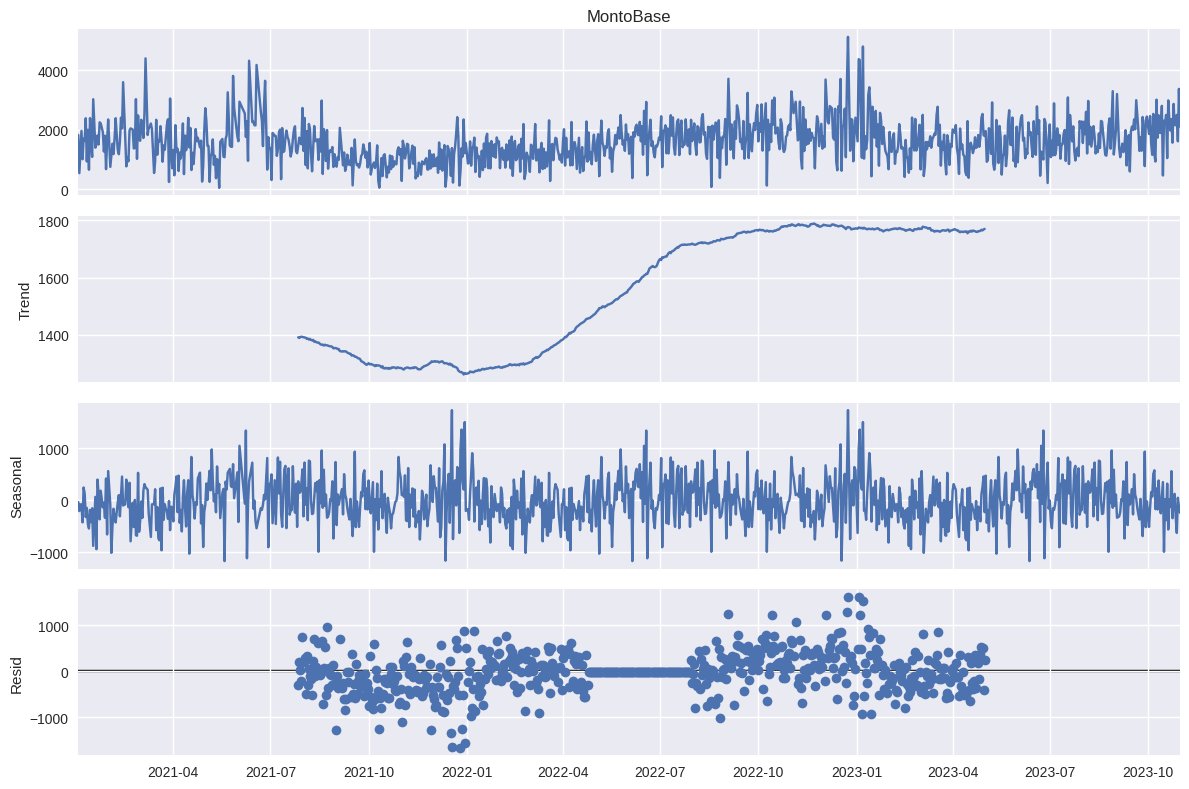

In [88]:
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df_arima_desde_2021["MontoBase"], model = "add", period=365)
a.plot();

In [89]:
# dividir en orden cronologico, entrenando sin el mes de octubre
train_size_d21 = int(len(df_arima_desde_2021) - 31)
train_d21, test_d21 = df_arima_desde_2021[0:train_size_d21], df_arima_desde_2021[train_size_d21:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
train_d21.shape, test_d21.shape

((967, 1), (31, 1))

In [91]:
print(train_d21)

                 MontoBase
FechaMovimiento           
2021-01-02       1822.6310
2021-01-03        543.4340
2021-01-04       1221.7920
2021-01-05       1963.7850
2021-01-06       1012.1080
...                    ...
2023-09-26       2428.3650
2023-09-27       2002.2241
2023-09-28        779.7913
2023-09-29       2314.3827
2023-09-30       2443.0856

[967 rows x 1 columns]


In [92]:
# # posibles valores para m = 7_diarios, 12_mensuales, 52_semanales
# modelo_auto=auto_arima(train_d21,start_p=0,d=1,start_q=0,
#           max_p=4,max_d=2,max_q=4, start_P=0,
#           D=1, start_Q=0, max_P=2,max_D=1,
#           max_Q=2, m=12, seasonal=True,
#           error_action='warn',trace=True,
#           supress_warnings=True,stepwise=True,
#           random_state=20,n_fits=50)
# print(modelo_auto)
# # ## se tiene el problema de q se usa toda la memoria RAM 12.7GB cuando se tiene m=365 (supuestamente periodos anuales)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
# print(modelo_auto.summary())

In [94]:
# arima_model_d21 = SARIMAX(train_d21["MontoBase"], order = (4,1,2), seasonal_order = (2,1,0,12))
arima_model_d21 = SARIMAX(train_d21["MontoBase"], order = (4,1,0), seasonal_order = (2,1,0,12))
arima_result_d21 = arima_model_d21.fit()
arima_result_d21.summary()



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/usr/local/lib/python3.10/dist-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/usr/local/lib/python3.10/dist-packages/pandas/core/

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          MontoBase   No. Observations:                  967
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -7698.719
Date:                            Sat, 02 Mar 2024   AIC                          15411.437
Time:                                    04:49:50   BIC                          15445.462
Sample:                                         0   HQIC                         15424.398
                                            - 967                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8339      0.029    -28.659      0.000      -0.891      -0.777
ar.L2         -0.5965      0.038    -15.836      0.000      -0.670      -0.523
ar.L3         -0.3950      0.034    -11.463      0.000      -0.463      -0.327
ar.L4         -0.1553      0.030     -5.150      0.000      -0.214      -0.096
ar.S.L12      -0.6375      0.029    -22.092      0.000      -0.694      -0.581
ar.S.L24      -0.3121      0.030    -10.236      0.000      -0.372      -0.252
sigma2      5.966e+05   2.37e+04     25.179      0.000     5.5e+05    6.43e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):                20.19
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                            -0.04
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [95]:
arima_pred_d21 = arima_result_d21.predict(start = len(train_d21), end = len(df_arima_desde_2021)-2, typ="levels").rename("ARIMA_Predictions_since_2021")
arima_pred_d21
# o start = 965 , end = 994 en primerasucursal
# o start = 967 , end = 996 en segundasucursal

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['ty

967   2167.5348
968   2400.8049
969   2129.6510
970   2556.5661
971   2116.9979
972   1793.3458
973   1875.6824
974   2059.1912
975   2716.7871
976   1743.6580
977   2167.1751
978   2415.5076
979   2269.5257
980   2581.9136
981   2388.4591
982   2543.8743
983   1786.6264
984   2028.4305
985   2017.3307
986   2072.1844
987   2591.9982
988   1891.7072
989   2508.4401
990   2751.8869
991   2504.4353
992   2999.7195
993   2680.5597
994   2725.1541
995   2088.1435
996   2214.3843
Name: ARIMA_Predictions_since_2021, dtype: float64

In [96]:
arima_pred_d21.index = df_noviembre_desde_2021.index

# Ahora puedes ver las predicciones con el índice correcto
print(arima_pred_d21)

0    2167.5348
1    2400.8049
2    2129.6510
3    2556.5661
4    2116.9979
5    1793.3458
6    1875.6824
7    2059.1912
8    2716.7871
9    1743.6580
10   2167.1751
11   2415.5076
12   2269.5257
13   2581.9136
14   2388.4591
15   2543.8743
16   1786.6264
17   2028.4305
18   2017.3307
19   2072.1844
20   2591.9982
21   1891.7072
22   2508.4401
23   2751.8869
24   2504.4353
25   2999.7195
26   2680.5597
27   2725.1541
28   2088.1435
29   2214.3843
Name: ARIMA_Predictions_since_2021, dtype: float64


<ipython-input-97-95a0eb4daed8>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0      2023-11-01  1999.7321       1938.0934    1876.2458
1      2023-11-02  1011.2892       1740.8432    1891.0087
2      2023-11-03  2343.7883       1963.4582    1922.4501
3      2023-11-04  1673.2089       2315.8646    1924.2942
4      2023-11-05  1181.9289       1502.5276    1888.0273
  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0      2023-11-01  1999.7321       1938.0934    1876.2458
1      2023-11-02  1011.2892       1740.8432    1891.0087
2      2023-11-03  2343.7883       1963.4582    1922.4501
3      2023-11-04  1673.2089       2315.8646    1924.2942
4      2023-11-05  1181.9289       1502.5276    1888.0273


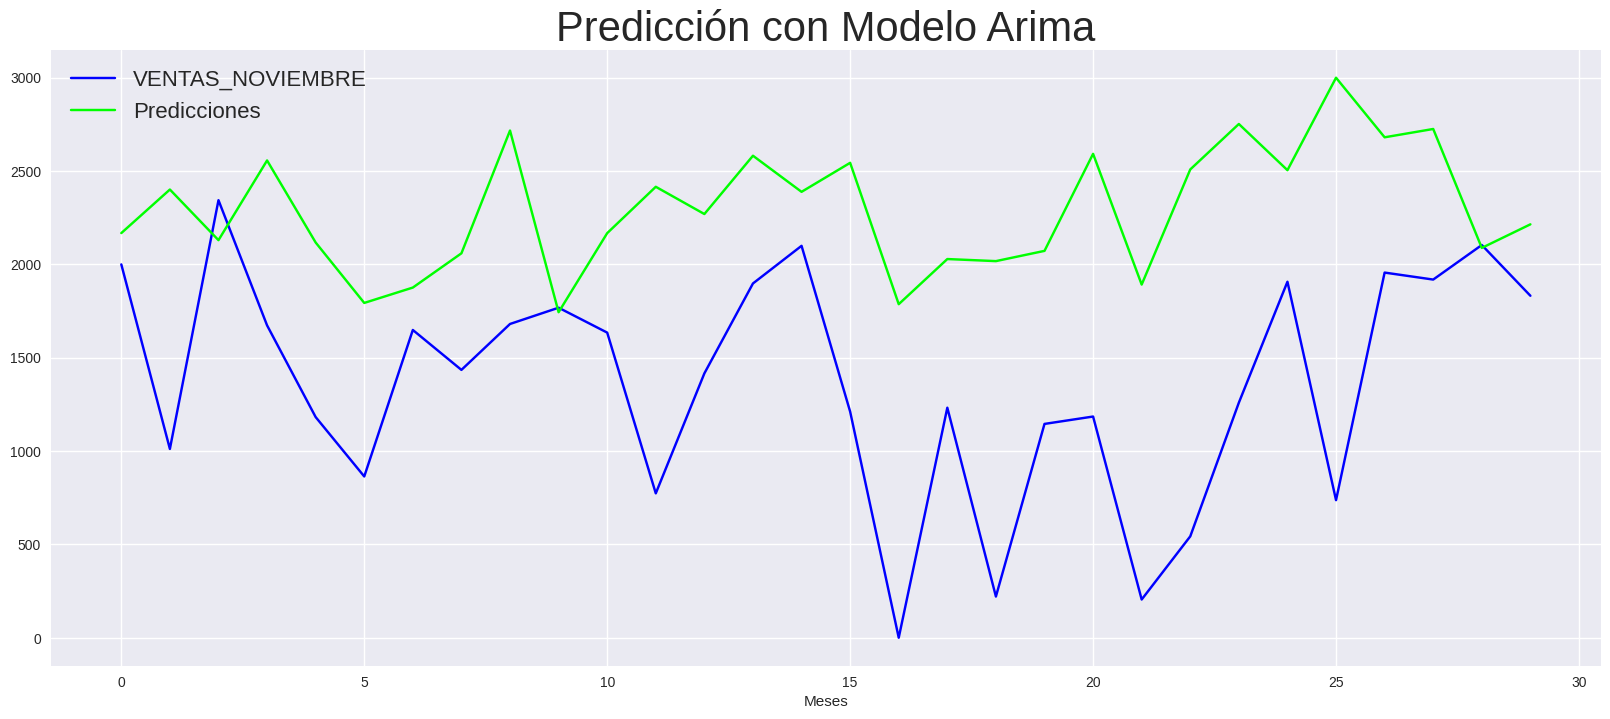

In [97]:
print(df_noviembre_desde_2021.head())
#df_noviembre_desde_2021.set_index('FechaMovimiento', inplace=True)
print(df_noviembre_desde_2021.head())

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)
#plt.plot(test_d21["MontoBase"],color="blue" ,label="VENTAS")
plt.plot(df_noviembre_desde_2021["MontoBase"],color="BLUE" ,label="VENTAS_NOVIEMBRE")
plt.plot(arima_pred_d21, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Meses')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

## Evaluar

In [98]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_desde_2021['Ventas_ARIMA'] = arima_pred_d21

# Imprimir el resultado
print(df_noviembre_desde_2021.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0       2023-11-01  1999.7321       1938.0934    1876.2458     2167.5348
1       2023-11-02  1011.2892       1740.8432    1891.0087     2400.8049
2       2023-11-03  2343.7883       1963.4582    1922.4501     2129.6510
3       2023-11-04  1673.2089       2315.8646    1924.2942     2556.5661
4       2023-11-05  1181.9289       1502.5276    1888.0273     2116.9979
5       2023-11-06   863.7984       1889.2897    1888.8846     1793.3458
6       2023-11-07  1648.4580       1762.6734    1860.7537     1875.6824
7       2023-11-08  1434.6711       1835.1293    1799.5127     2059.1912
8       2023-11-09  1680.6493       1619.1114    1810.4359     2716.7871
9       2023-11-10  1767.7892       1824.6313    1819.6488     1743.6580
10      2023-11-11  1634.3693       2162.0183    1850.3496     2167.1751
11      2023-11-12   773.2943       1336.0989    1872.0804     2415.5076
12      2023-11-13  1415.9722       1713.0265    18

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [99]:
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_ARIMA'])

Evaluation metric results:  
MSE is : 1256918.7445017425
MAE is : 947.171533983308
R2 is : -2.460672933097375 %
------------------------------
MRSE is : 1121.1238756273735
MAPE is : 131.12055557101488 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# TODAS LAS EVALUACIONES

In [100]:
print("--"*10,"EVALUACIÓN CON TODOS LOS DATOS","--"*10)
print("--"*5,"PROPHET","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_PROPHET'])
print("--"*5,"LSTM","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])
print("--"*5,"ARIMA","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_ARIMA'])
print("--"*10,"EVALUACIÓN DESDE EL 2021","--"*10)
print("--"*5,"PROPHET","--"*5)
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_PROPHET'])
print("--"*5,"LSTM","--"*5)
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_LSTM'])
print("--"*5,"ARIMA","--"*5)
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_ARIMA'])

-------------------- EVALUACIÓN CON TODOS LOS DATOS --------------------
---------- PROPHET ----------
Evaluation metric results:  
MSE is : 553976.3144819281
MAE is : 595.524865016847
R2 is : -0.5252623492894297 %
------------------------------
MRSE is : 744.2958514474793
MAPE is : 88.62104810873046 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------


---------- LSTM ----------
Evaluation metric results:  
MSE is : 740540.2350501155
MAE is : 662.6514758398439
R2 is : -1.038928577139976 %
------------------------------
MRSE is : 860.54647466021
MAPE is : 105.72054365196703 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------


---------- ARIMA ----------
Evaluation metric results:  
MSE is : 1846848.372502174
MAE is : 1184.707793191236
R2 is : -4.084925499131461 %
---------------

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-101-b2c06a3cd456>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


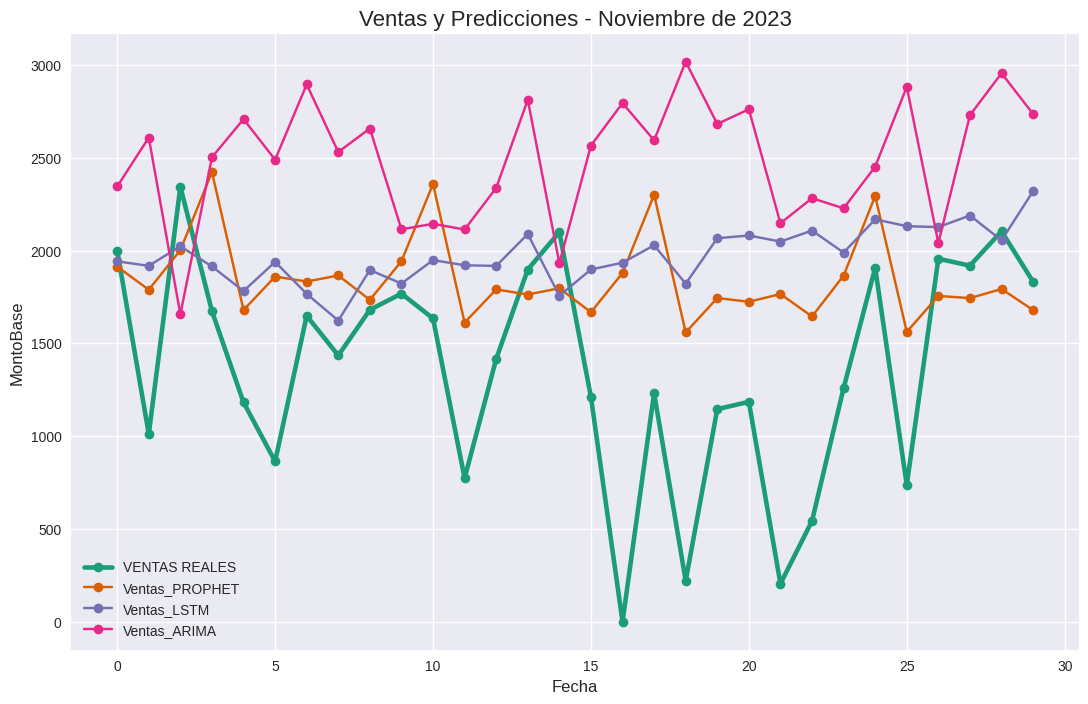

In [101]:
# Establecer el estilo de Seaborn
plt.style.use('seaborn')
sns.set_palette("Dark2")

# Graficar los datos para df_noviembre_sumaT
plt.figure(figsize=(13, 8))
plt.plot(df_noviembre_sumaT.index, df_noviembre_sumaT['MontoBase'], label='VENTAS REALES', marker='o', linewidth=3.3)
plt.plot(df_noviembre_sumaT.index, df_noviembre_sumaT['Ventas_PROPHET'], label='Ventas_PROPHET', marker='o')
plt.plot(df_noviembre_sumaT.index, df_noviembre_sumaT['Ventas_LSTM'], label='Ventas_LSTM', marker='o')
plt.plot(df_noviembre_sumaT.index, df_noviembre_sumaT['Ventas_ARIMA'], label='Ventas_ARIMA', marker='o')
plt.title('Ventas y Predicciones - Noviembre de 2023', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('MontoBase', fontsize=12)
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-102-aba6b4d63878>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


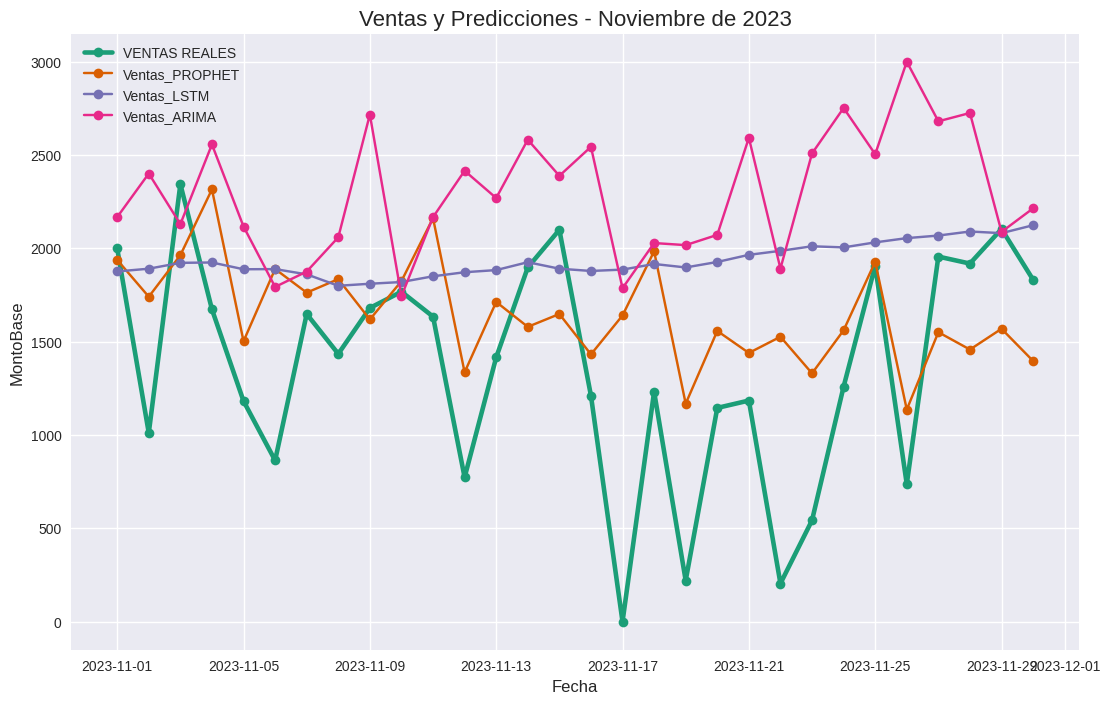

In [102]:
# Establecer el estilo de Seaborn
plt.style.use('seaborn')
sns.set_palette("Dark2")

# Graficar los datos para df_noviembre_desde_2021
plt.figure(figsize=(13, 8))
plt.plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['MontoBase'], label='VENTAS REALES', marker='o', linewidth=3.3)
plt.plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['Ventas_PROPHET'], label='Ventas_PROPHET', marker='o')
plt.plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['Ventas_LSTM'], label='Ventas_LSTM', marker='o')
plt.plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['Ventas_ARIMA'], label='Ventas_ARIMA', marker='o')
plt.title('Ventas y Predicciones - Noviembre de 2023', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('MontoBase', fontsize=12)
plt.legend()
plt.show()